## Data Info

########################################

The ExtraSensory Dataset

Primary data files (features and labels)

########################################

The ExtraSensory Dataset was collected by
Yonatan Vaizman and Katherine Ellis, with the supervision of Gert Lanckriet.
Department of Electrical and Computer Engineering,
University of California, San Diego.

The dataset is publicly available.
Any usage of the dataset for publications requires citing the official paper that introduced the dataset:
Vaizman, Y., Ellis, K., and Lanckriet, G. "Recognizing Detailed Human Context In-the-Wild from Smartphones and Smartwatches".
IEEE Pervasive Computing, vol. 16, no. 4, October-December 2017, pp. 62-74. doi:10.1109/MPRV.2017.3971131
(In the website, we refer to this original paper as Vaizman2017a)

########################################

Content of the primary data files:
There are 60 'csv.gz' files, one for each participant (user, subject) in the data collection.
Each of these files has filename with the form:
[UUID].features_labels.csv.gz
where each user has a unique (randomly generated) universal user identification (UUID) number.
Each file is a textual CSV file, compressed using the gzip format.

Within every user's CSV file:
-----------------------------
- The first row specifies the columns of the file.
- Every other row refers to an example from the user. The examples are sorted according to the primary key - the timestamp.
- The columns:

-- First column is 'timestamp'. This is represented as standard number of seconds since the epoch.

-- Second, come columns for the extracted features.
   Unavailable features are represented with 'nan'.
   The name of each feature contains reference to the sensor it was extracted from, in the form [sensor_name]:[feature_name].
   The current version contains features from the following sensors, with sensor names:
--- raw_acc: Accelerometer from the phone. The 'raw' version of acceleration (as opposed to the decomposed versions of gravity and user-acceleration).   
--- proc_gyro: Gyroscope from the phone. Processed version of gyroscope measurements (the OS calculates a version that removes drift).
--- raw_magnet: Magnetometer from the phone. Raw version (as opposed to bias-fixed version that the OS also provides).
--- watch_acceleration: Accelerometer from the watch.
--- watch_heading: Heading from the compass on the watch.
--- location: Location services. These features were extracted offline for every example from the sequence of latitude-longitude-altitude updates from the example's minute.
              These features regard only to relative-location (not absolute location in the world) - meaning, they describe variability of movement within the minute.
--- location_quick_features: Location services. These features were calculated on the phone when data was collected. 
                             These are available even in cases that the other location features are not because the user wanted to conceal their absolute location coordinates.
							 These quick features are very simple heuristics that approximate the more thoughtful offline features.
--- audio_naive: Microphone. These naive features are simply averages and standard deviations of the 13 MFCCs from the ~20sec recording window of every example.
--- discrete: Phone-state. These are binary indicators for the state of the phone.
              Notice that time_of_day features are also considered phone-state features (also have prefix 'discrete:'), but their columns appear not right after the other 'discrete' columns.
--- lf_measurements: Various sensors that were recorded in low-frequency (meaning, once per example).

-- Third, come columns for the ground truth labels.
   The values are either 1 (label is relevant for the example), 0 (label is not relevant for the example), or 'nan' (label is considered 'missing' for this example).
   Originally, users could only report 'positive' labels (in the original ExtraSensory paper, Vaizman2017a, we assumed that when a label was not reported it is a 'negative' example).
   This cleaned version of the labels has the notion of 'missing labels'; Details about how we inferred missing label information is provided in the second paper, Vaizman2017b (see http://extrasensory.ucsd.edu for updated references).
   The names of the labels have prefix 'label:'. After the prefix:
   If the label name is all capitalized, it is an original label from the mobile app's interface and the values were taken from what the user originally reported.
   If the label name begins with 'FIX_', this is a fixes/cleaned version of a corresponding label, meaning that the researchers fixed some of the values that were reported by users because of inconsistencies.
   If the label name begins with 'OR_', this is a synthesized label, meaning it did not appear in the app's label menu, but rather the researchers created it as combination (using logical or) of other related labels.
   If the label name begins with 'LOC_', this is a fixed/cleaned version of a corresponding label that was fixed by researchers based on absolute location.
      LOC_beach was based on original label 'AT_THE_BEACH'.
	  LOC_home was based on original label 'AT_HOME'.
	  LOC_main_workplace was based on original label 'AT_WORK'.

-- Fourth, the last column is label_source, describing where the original labeling came from in the mobile app's interface. It has 8 possible values:
   -1: The user did not report any labels for this example (notice, however, that this example may still have labeling for the 'LOC_' labels).
   0 : The user used the 'active feedback' interface (reporting immediate future). This example is the first in relevant minute sequence.
   1 : The user used the 'active feedback' interface. This example is a continuation of a sequence of minutes since the user started the reported context.
   2 : The user used the history interface to label an example from the past.
   3 : The user replied to a notification that simply asked to provide any labels.
   4 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'correct' on the phone.
   5 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'not exactly' and then corrected the context labels.
   6 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'correct' on the watch interface.


########################################

## Data Consolidation
Getting the data from all the different files into one csv.

Game plan from here:
new csv file for generated labels and real labels 
model that I am working on (using lstm model to predict next USER DATA & next activity prediction and create a row for it) concat into singular CSV (don't have to rename files beforehand) 

Two csv files ? 

Possibly use labels to predict next user data 


In [1]:
# Standard library imports
import gzip
import os
import shutil
import zipfile
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# Related third-party imports
from IPython.display import Markdown, display
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skmultilearn.problem_transform import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Making sure ExtraSensory.per_uuid_features_labels.zip exists and is unziped

def unzip(zip_file):
    # Extract to the directory obtained from the zip file name
    zip_extract_to = zip_file.replace('.zip', '')

    # Unzipping
    if os.path.exists(zip_file):
        if not os.path.exists(zip_extract_to):
            os.makedirs(zip_extract_to)
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(zip_extract_to)
            message = "Unzipped successfully."
        else:
            message = "Directory already exists. File might be unzipped."
    else:
        message = "Zip file not found."

    print(message)
    return zip_extract_to


def csv_extract(zip_extract_to):
    # Improved variable name for the directory where the extracted files will be saved
    unzipped_data_dir = f"{zip_extract_to}-Unzipped"

    # Create the unzipped data directory if it does not exist
    if not os.path.exists(unzipped_data_dir):
        os.makedirs(unzipped_data_dir)

    # Extracting .csv.gz files
    extraction_message = ""
    if os.path.exists(zip_extract_to):
        for file in os.listdir(zip_extract_to):
            if file.endswith('.gz'):
                gz_file_path = os.path.join(zip_extract_to, file)
                csv_file_path = os.path.join(unzipped_data_dir, file[:-3])  # Removing '.gz' from filename

                try:
                    with gzip.open(gz_file_path, 'rb') as f_in:
                        with open(csv_file_path, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                    extraction_message += f"Extracted {file}\n"
                except Exception as e:
                    extraction_message += f"Error extracting {file}: {e}\n"
    else:
        extraction_message = "Directory with .gz files not found."

    print(extraction_message.strip())

    return unzipped_data_dir


# Function to extract user_id from filename
def extract_user_id(filename):
    return filename.split('.')[0]

def make_one_csv(unzipped_data_dir, COMBINED_FILE):
    # Combining all CSVs into one dataframe
    combined_csv_data = pd.DataFrame()

    if os.path.exists(unzipped_data_dir):
        for file in os.listdir(unzipped_data_dir):
            if file.endswith('.csv'):
                file_path = os.path.join(unzipped_data_dir, file)
                user_id = extract_user_id(file)

                # Read the CSV file and add the user_id column
                csv_data = pd.read_csv(file_path)
                csv_data['user_id'] = user_id

                # Append to the combined dataframe
                combined_csv_data = pd.concat([combined_csv_data, csv_data], ignore_index=True)

                
                #print(f"Processed file: {file} \nCurrent size of combined data: {combined_csv_data.shape}")


        # Check if any data has been combined
        if not combined_csv_data.empty:
            # Save the combined CSV data to a file
            combined_csv_data.to_csv(COMBINED_FILE, index=False)
            print(f"Combined CSV file created at {COMBINED_FILE}.")
        else:
            print("No CSV files found to combine or combined data is empty.")
    else:
        print("Directory with unzipped CSV files not found.")
    return COMBINED_FILE



In [4]:
COMBINED_FILE = 'ExtraSensory_Combined_User_Data.csv'
if not os.path.exists(COMBINED_FILE):
    # Path of the zip file
    zip_file = 'ExtraSensory.per_uuid_features_labels.zip'
    zip_extract_to = unzip(zip_file)
    unzipped_data_dir = csv_extract(zip_extract_to)
    make_one_csv(unzipped_data_dir, COMBINED_FILE)
else:
    print('Combined file already exists.')


Combined file already exists.


## Data Exploration

In [5]:
combined_csv_data = pd.read_csv(COMBINED_FILE)
combined_csv_data['timestamp'] = pd.to_datetime(combined_csv_data['timestamp'], unit='s')

In [6]:
print(combined_csv_data.columns)

# user_id is for us to make sure we have record on source of the data. 

Index(['timestamp', 'raw_acc:magnitude_stats:mean',
       'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3',
       'raw_acc:magnitude_stats:moment4',
       'raw_acc:magnitude_stats:percentile25',
       'raw_acc:magnitude_stats:percentile50',
       'raw_acc:magnitude_stats:percentile75',
       'raw_acc:magnitude_stats:value_entropy',
       'raw_acc:magnitude_stats:time_entropy',
       ...
       'label:ELEVATOR', 'label:OR_standing', 'label:AT_SCHOOL',
       'label:PHONE_IN_HAND', 'label:PHONE_IN_BAG', 'label:PHONE_ON_TABLE',
       'label:WITH_CO-WORKERS', 'label:WITH_FRIENDS', 'label_source',
       'user_id'],
      dtype='object', length=279)


In [7]:
# Trying to understand columns
def build_hierarchy(columns):
    # Build a nested dictionary representing the hierarchy of columns.
    hierarchy = {}
    for col in columns:
        parts = col.split(':')
        current_level = hierarchy

        for part in parts[:-1]:
            current_level = current_level.setdefault(part, {})
        
        current_level[parts[-1]] = col

    return hierarchy

def format_hierarchy(hierarchy, indent=0):
    # Format the hierarchy into a readable string with indentation.
    result = ""
    for key, value in hierarchy.items():
        prefix = "  " * indent + "- "
        if isinstance(value, dict):
            result += f"{prefix}{key}:\n{format_hierarchy(value, indent + 1)}"
        else:
            result += f"{prefix} {key}\n"
    return result

# Building and formatting the hierarchy
hierarchy = build_hierarchy(combined_csv_data.columns)
formatted_hierarchy = format_hierarchy(hierarchy)
print(formatted_hierarchy)

-  timestamp
- raw_acc:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  mean_x
    -  mean_y
    -  mean_z
    -  std_x
    -  std_y
    -  std_z
    -  ro_xy
    -  ro_xz
    -  ro_yz
- proc_gyro:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  me

In [8]:
# List of label columns to check
label_columns = [col for col in combined_csv_data.columns if col.startswith("label:")]

# Assumption of negatives for ground truths
combined_csv_data[label_columns] = combined_csv_data[label_columns].fillna(0)

combined_csv_data['label_sum_inital'] = combined_csv_data[label_columns].sum(axis=1)
combined_csv_data['label:UNKNOWN'] = (combined_csv_data['label_sum_inital'] == 0).astype(float)
label_columns.append('label:UNKNOWN')
combined_csv_data = combined_csv_data.drop('label_sum_inital', axis=1)
df = combined_csv_data.copy()


# Function to find the label name with value 1
def find_label_name(row):
    for col in label_columns:
        if row[col] == 1:
            return col.split("label:")[1]
    return None

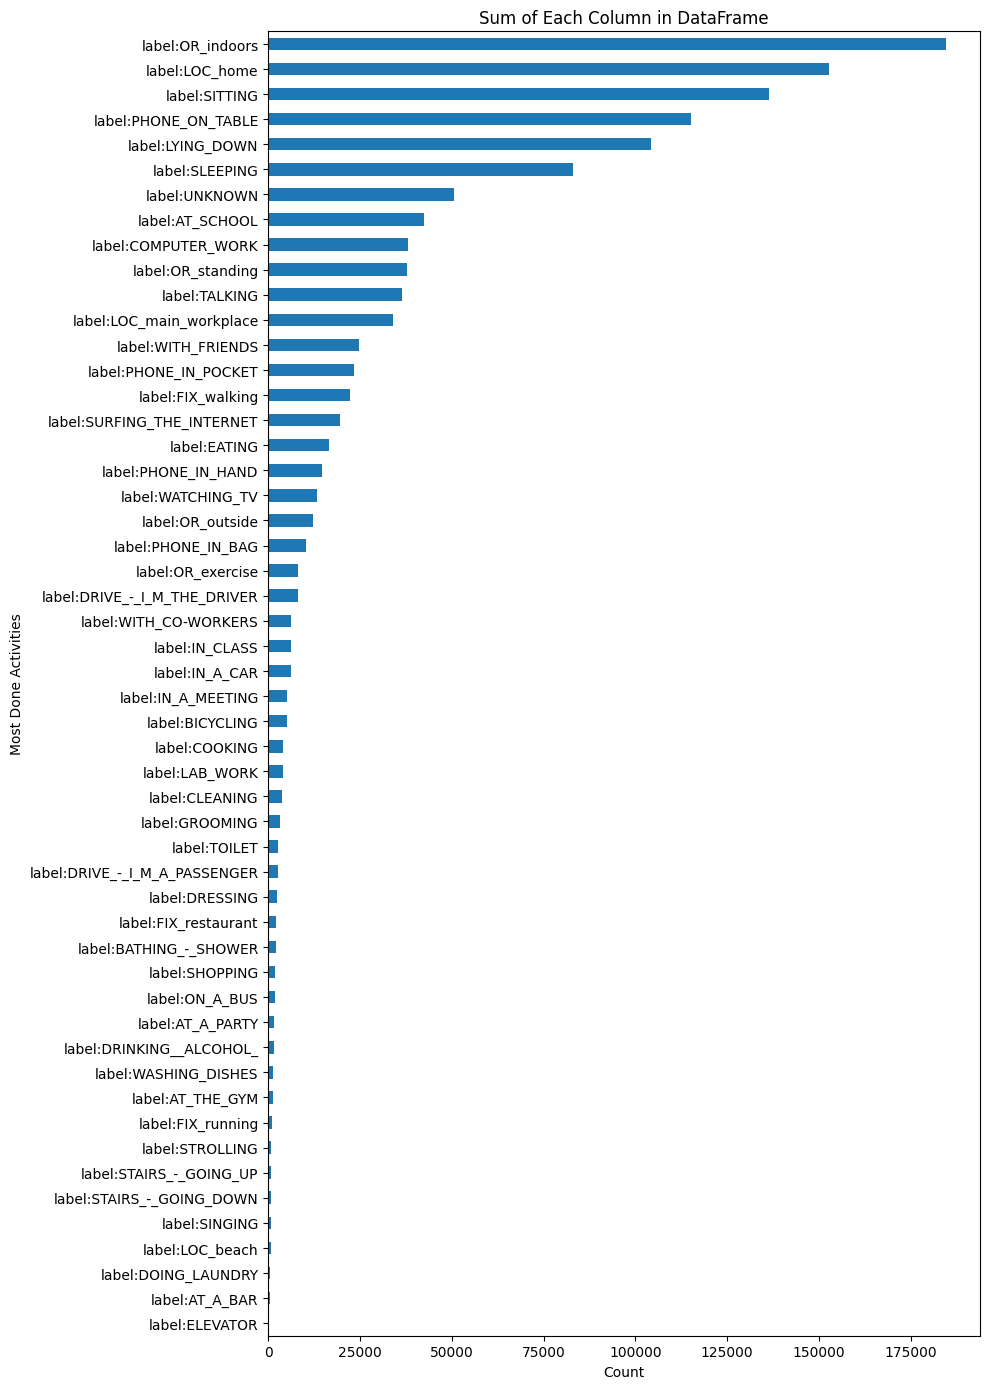

In [9]:
# Checking ground truth labels for value counts
column_sums = df[label_columns].sum()
column_sums_sorted = column_sums.sort_values(ascending=True)

# Plot setup
plt.figure(figsize=(10, 14)) 
column_sums_sorted.plot(kind='barh')
plt.title('Sum of Each Column in DataFrame')
plt.xlabel('Count')
plt.ylabel('Most Done Activities')
plt.tight_layout()
plt.show()

In [10]:
# Deleting the other columns
unneeded_columns = ['user_id', 'label_source']
output_columns = [col for col in combined_csv_data.columns if col.startswith('label:')]
input_columns = [col for col in combined_csv_data.columns if col not in output_columns and col not in unneeded_columns]
X_main = df.copy()[input_columns]

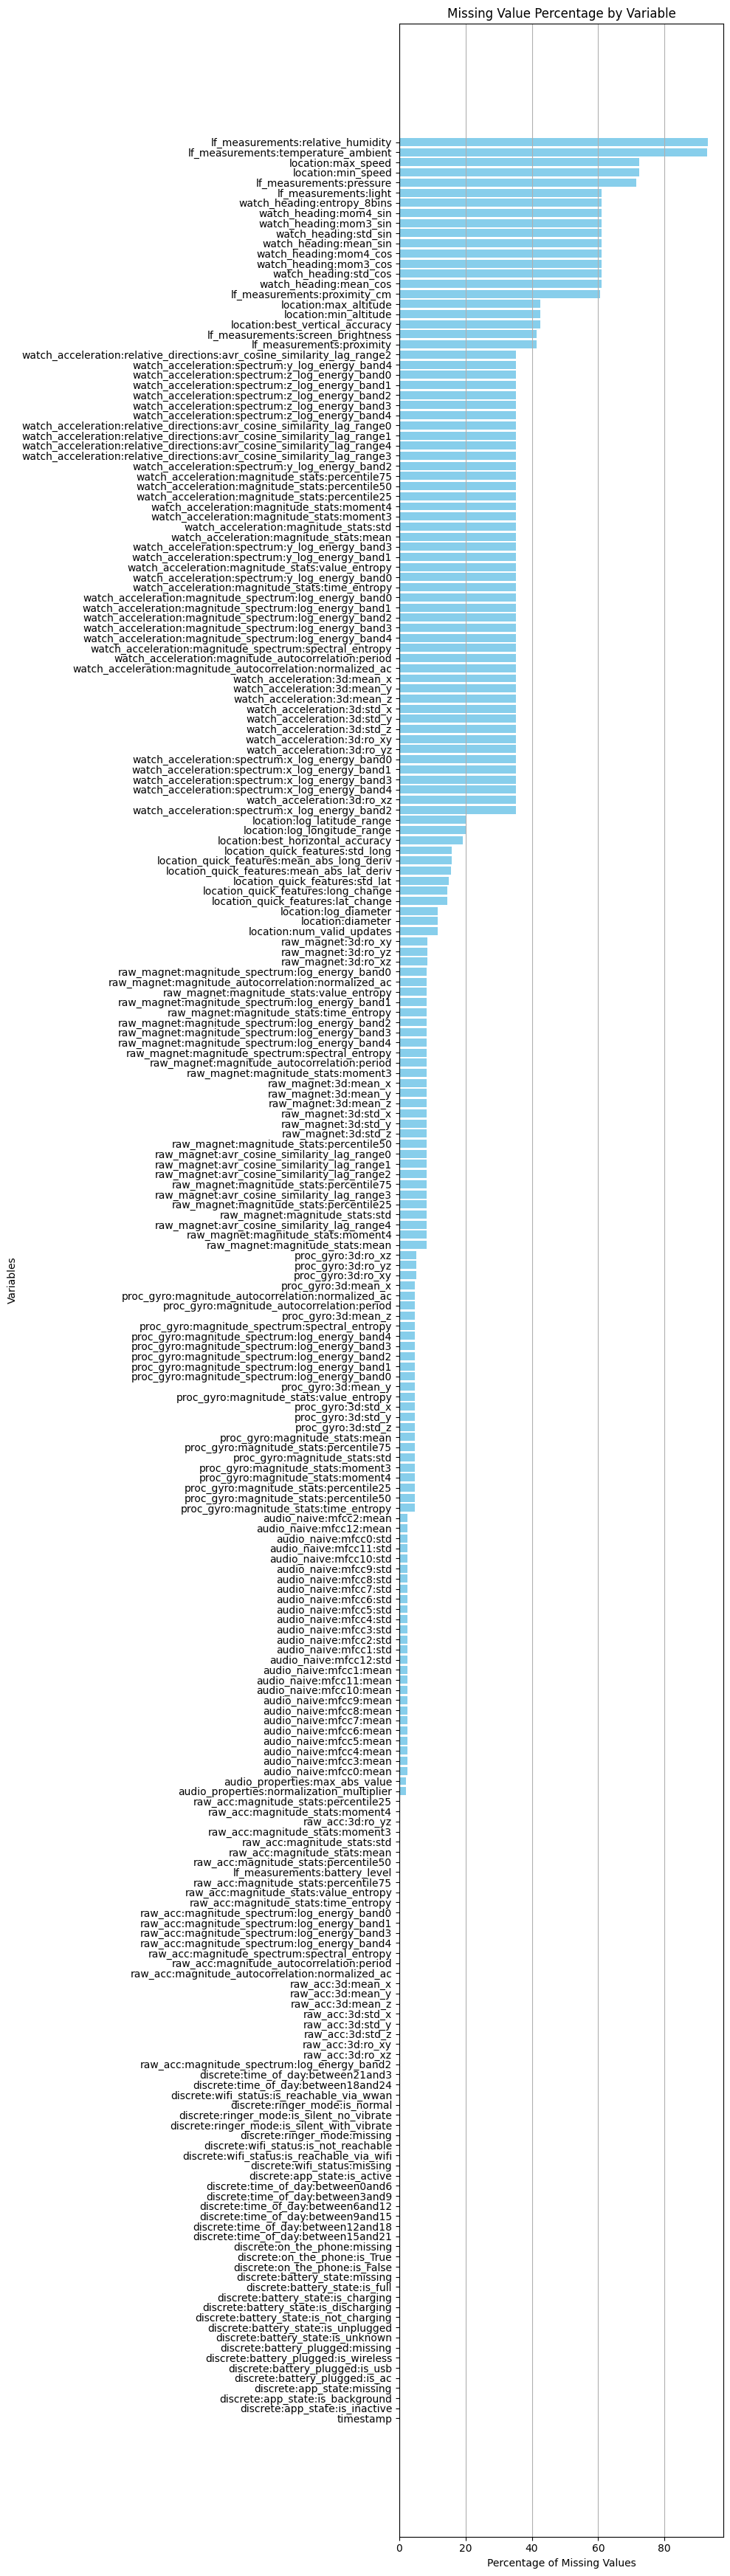

In [11]:
# Checking input variables for missing values
def nan_percentage(df):
    nan_percentage = (df.isna().mean() * 100).round(2)
    nan_percentage_df = pd.DataFrame({'Variable': nan_percentage.index, 'NaN Percentage': nan_percentage.values})
    nan_percentage_df = nan_percentage_df.sort_values(by='NaN Percentage', ascending=True)
    
    # Plot setup
    plt.figure(figsize=(10, 35)) 
    plt.barh(nan_percentage_df['Variable'], nan_percentage_df['NaN Percentage'], color='skyblue')
    plt.xlabel('Percentage of Missing Values')
    plt.ylabel('Variables')
    plt.title('Missing Value Percentage by Variable')
    plt.grid(axis='x')
    plt.tight_layout() 
    plt.show()
    return nan_percentage_df

# Checking overall missing percentage
nan_percentage_df = nan_percentage(X_main)

In [12]:
X_with_users = df.drop(columns=['label_source'])

In [13]:
users = X_with_users['user_id'].unique()
len(users)

60

In [14]:
features = input_columns

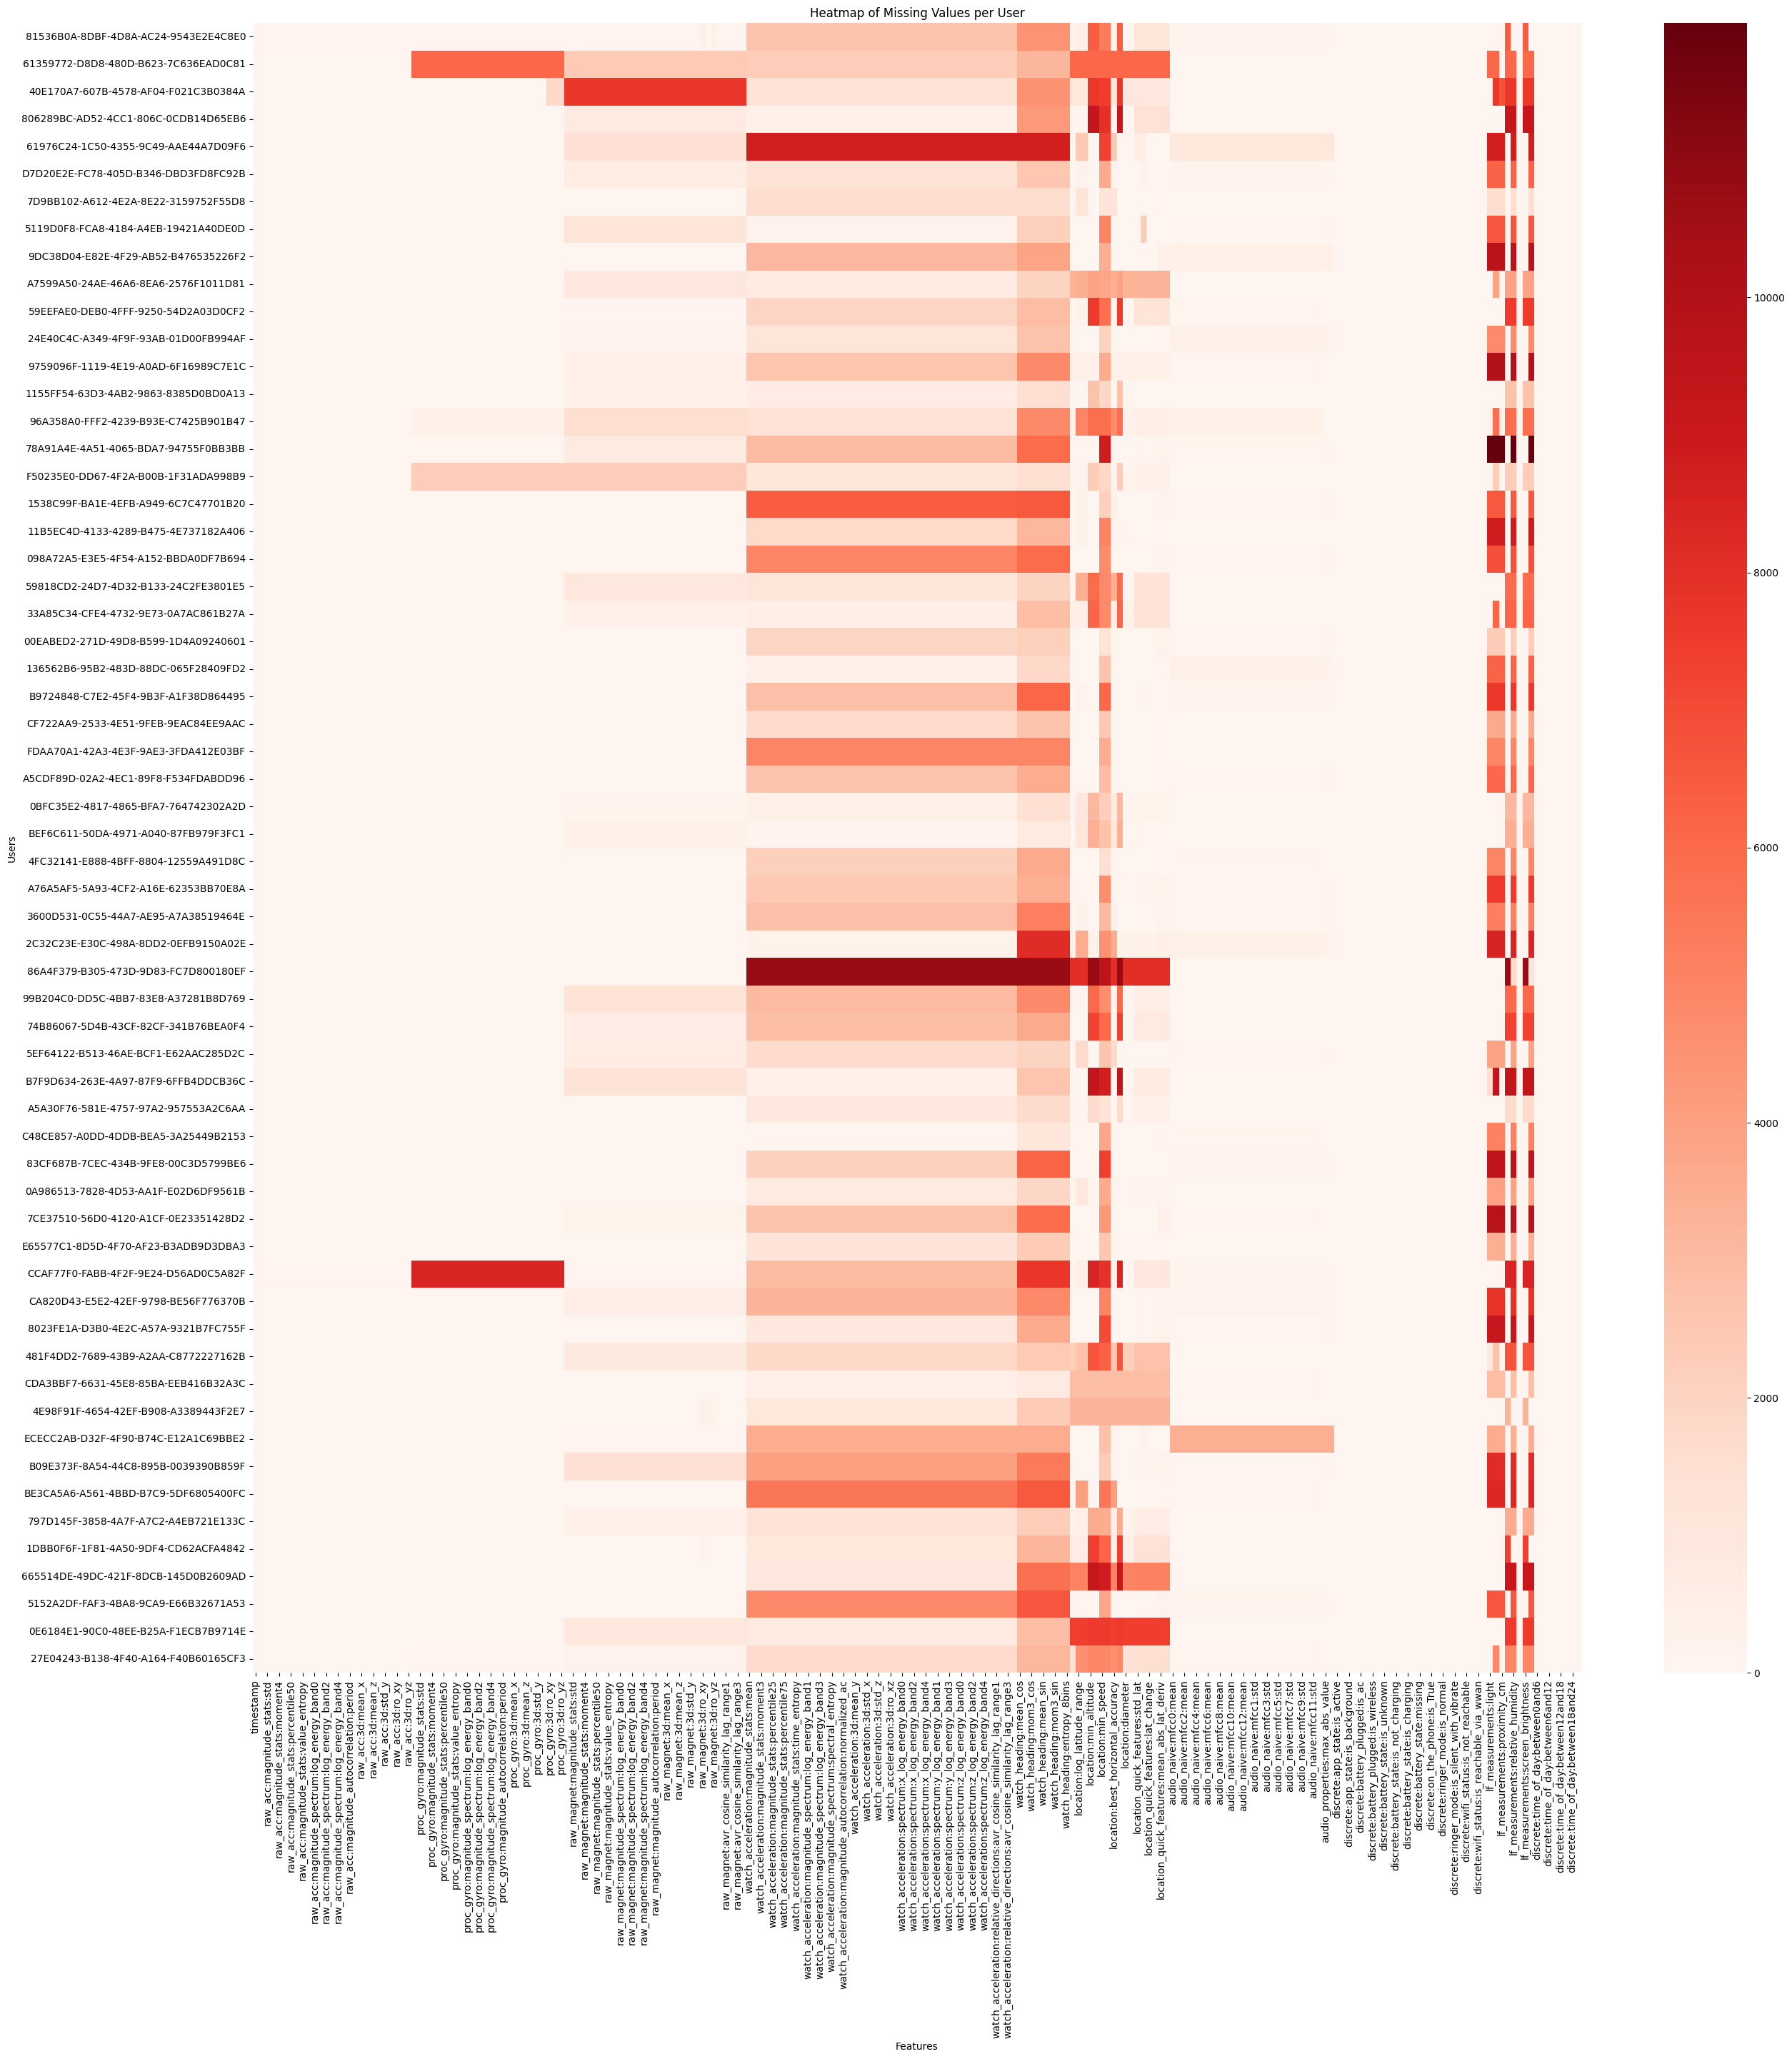

In [15]:
# Initialize a list to store the counts for each user
nan_counts_list = []

# Loop through each user
for user in users:
    # Filter the DataFrame for the current user
    df_user = X_with_users[X_with_users['user_id'] == user]
    
    # Count the NaN values for each feature for the current user and add user_id to the series
    nan_count = df_user[features].isna().sum()
    nan_count['user_id'] = user  # Add user_id to the count
    
    # Append the count series to the list
    nan_counts_list.append(nan_count)

# Convert the list of Series to a DataFrame
nan_counts_per_user = pd.DataFrame(nan_counts_list)

# If needed, set the user_id as the index
nan_counts_per_user.set_index('user_id', inplace=True)


# Plot the heat map
plt.figure(figsize=(30, 30))
sns.heatmap(nan_counts_per_user, annot=False, cmap='Reds')
plt.title('Heatmap of Missing Values per User')
plt.xlabel('Features')
plt.ylabel('Users')
plt.show()

In [16]:
# Calculate the total number of rows for each user in the original DataFrame
user_total_length = X_with_users.groupby('user_id').size()

# Convert this to a DataFrame or a Series that can be added to nan_counts_per_user
user_total_length_df = user_total_length.to_frame(name='total_length')

# Merge this information with nan_counts_per_user
# Since nan_counts_per_user already has user_id as its index, we can directly add the new column
nan_counts_per_user['total_length'] = user_total_length_df['total_length']

# Now, nan_counts_per_user includes the total_length column

In [17]:

# Calculate the total NaN count for each feature across all users
total_nan_counts = nan_counts_per_user.sum()

# Assuming `X_with_users` is your original DataFrame and has the same number of entries for each user,
# Calculate the total number of entries for a single feature across all users
total_entries_per_feature = len(X_with_users)  # Or, more specifically, len(users) * average_entries_per_user if varies

# Calculate the percentage of missing data for each feature
percentage_missing = (total_nan_counts / total_entries_per_feature) * 100


# Decide on a threshold for removing columns, e.g., 1%
threshold = 0

# Identify columns that exceed this threshold
columns_to_remove = percentage_missing[percentage_missing > threshold].index.tolist()

print("Removing ", len(columns_to_remove),"columns out of ", len(X_with_users.columns))
# Print out the columns to remove
# print("Columns to remove due to excessive missing data:", columns_to_remove)

features_to_include = [feature for feature in features if feature not in columns_to_remove]

if 'timestamp' in X_with_users.columns:
    X_with_users['timestamp_numeric'] = X_with_users['timestamp'].astype(np.int64) // 10**9
    # Ensure 'timestamp_numeric' is included and 'timestamp' is excluded from features_to_include
    features_to_include = [f for f in features_to_include if f != 'timestamp'] + ['timestamp_numeric']

# Continue with your existing preprocessing...
user_df = X_with_users[X_with_users['user_id'] == users[-1]]
median_values = user_df[features_to_include].median()
user_df = user_df[features_to_include].fillna(median_values)


Removing  192 columns out of  279


#### Testing to see if we need to do Binary Relevance, or Classifier chains. We can also check Label Powerset, but the issue is combinations can become very large since we have 52 labels. 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


combined_csv_data_4_model = combined_csv_data.copy()
combined_csv_data_4_model['timestamp_numeric'] = combined_csv_data_4_model['timestamp'].astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])
X = combined_csv_data_4_model[features_to_include]
y = combined_csv_data_4_model[output_columns]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

<Figure size 2000x2000 with 0 Axes>

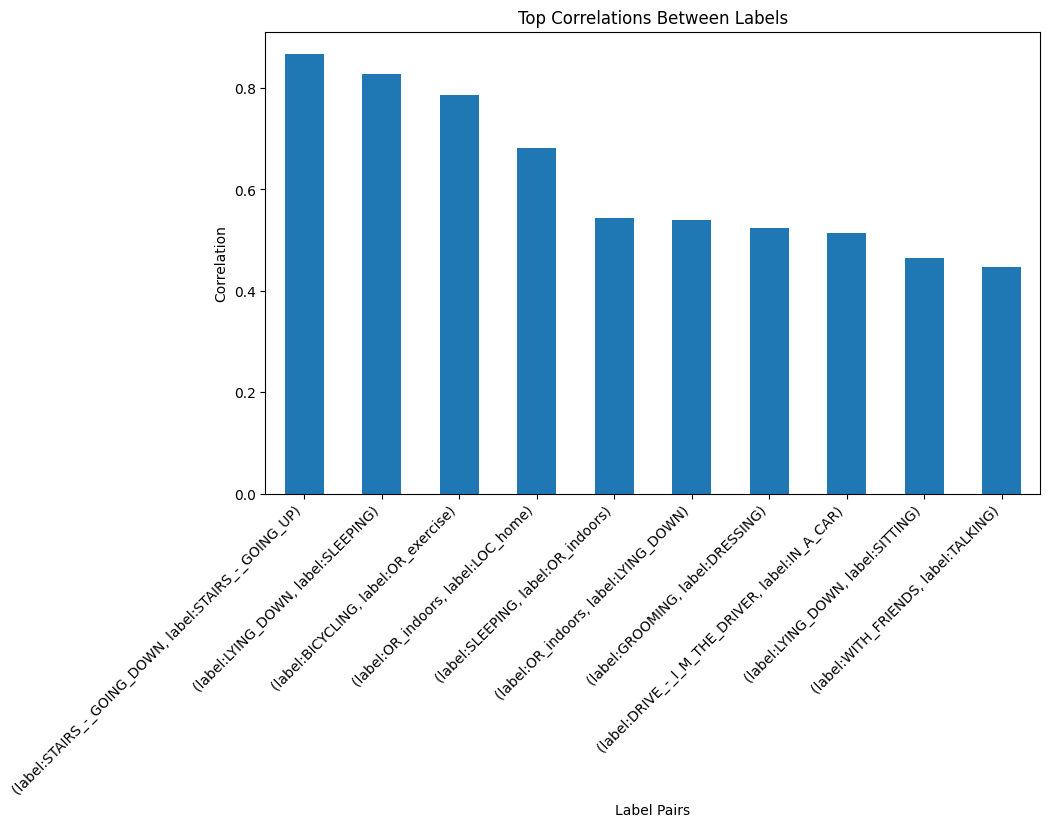

In [19]:
plt.figure(figsize = (20,20))
corr_matrix = y.corr(method = 'pearson')  # Compute the correlation matrix

# Flatten the matrix, sort by absolute value while preserving names
corr_flat = corr_matrix.unstack()
corr_flat_sorted = corr_flat.abs().sort_values(ascending=False)

# Remove self-correlations
corr_flat_sorted = corr_flat_sorted[corr_flat_sorted < 1]

# Take the top N correlations for plotting (for simplicity, let's plot all unique pairs)
unique_pairs = corr_flat_sorted.drop_duplicates().head(10)

# Plotting
plt.figure(figsize=(10, 6))
unique_pairs.plot(kind='bar')
plt.title('Top Correlations Between Labels')
plt.xlabel('Label Pairs')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.show()

Seems like there is a corrolation, lets do Classifier chains. 

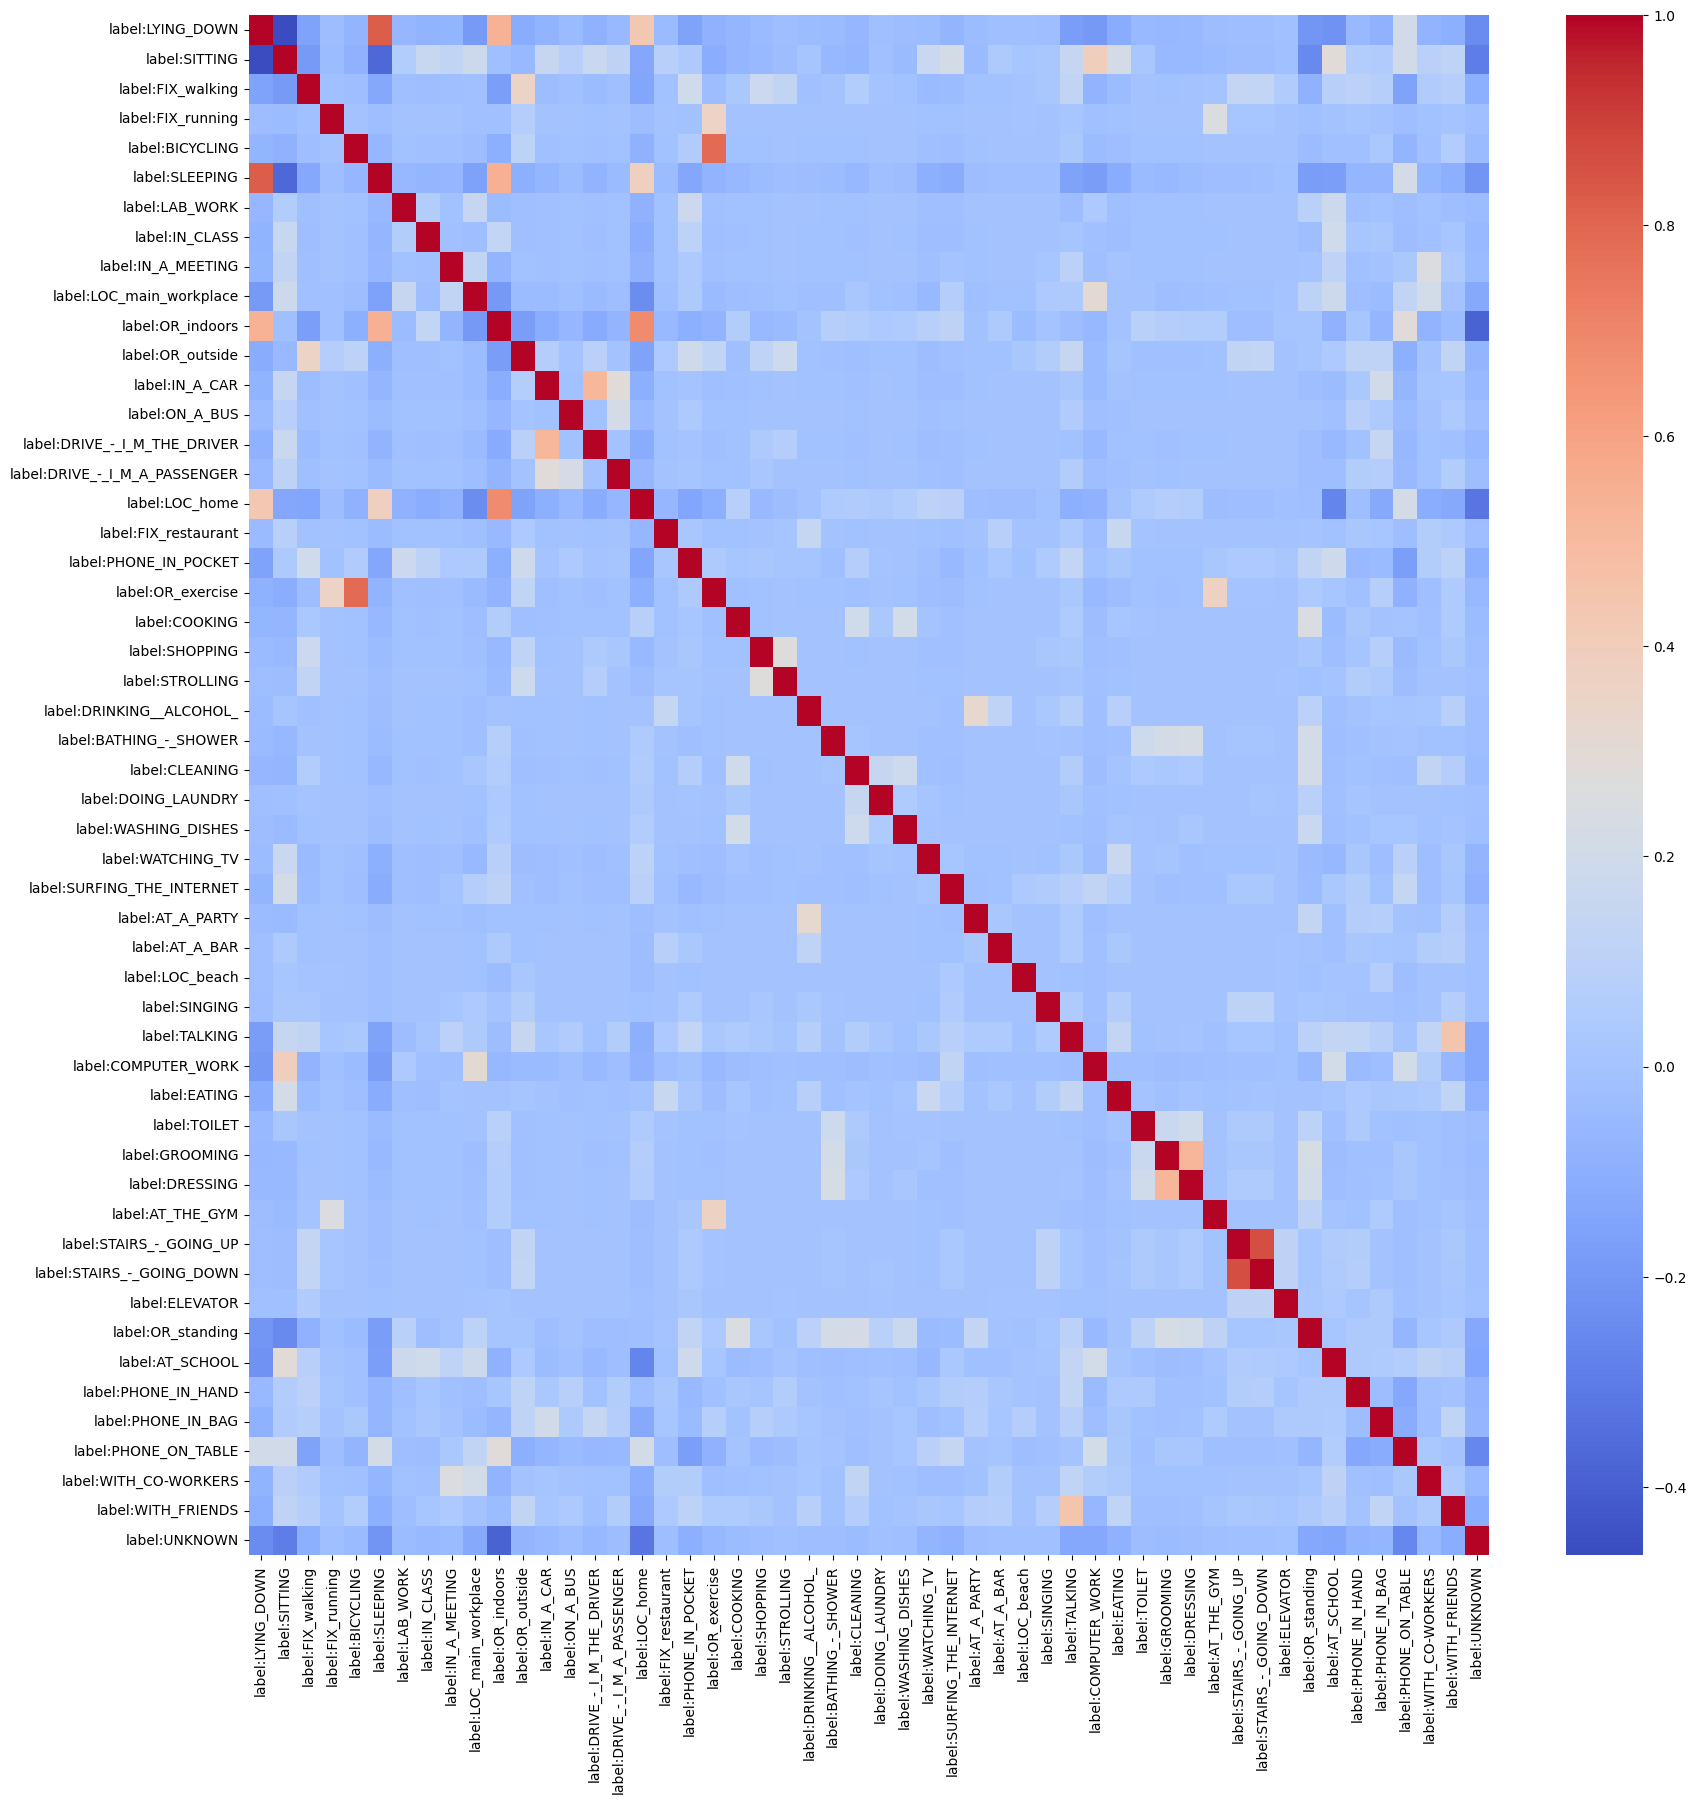

In [20]:
plt.figure(figsize = (20,20))
corr = y.corr(method = 'pearson')
corr_flat = corr.unstack().sort_values(ascending =False)

sns.heatmap(corr, annot = False, cmap = 'coolwarm')
plt.show()

In [21]:
combined_csv_data.shape

(377346, 280)

In [22]:

combined_csv_data_4_model = combined_csv_data.iloc[:37734,:].copy()
combined_csv_data_4_model['timestamp_numeric'] = combined_csv_data_4_model['timestamp'].astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])
X = combined_csv_data_4_model[features_to_include]
y = combined_csv_data_4_model[output_columns]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [23]:
# Initialize Classifier Chain with a RandomForest base classifier
classifier = ClassifierChain(RandomForestClassifier())

# Train the Classifier Chain model
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Note: accuracy_score expects single-label predictions,
# so for multi-label you might use another metric like hamming loss or a subset accuracy function
# Here's an example with a custom subset accuracy for multi-label
def subset_accuracy(y_true, y_pred):
    return (y_true == y_pred).all(axis=1).mean()

print("Subset Accuracy: ", subset_accuracy(y_test, predictions.toarray()))

Subset Accuracy:  0.9565390221279979


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import pickle

user = users[0]

models_data = {
    'models': {},
    'accuracies': {}
}


In [25]:


combined_csv_data_4_model = combined_csv_data.copy()
combined_csv_data_4_model['timestamp_numeric'] = combined_csv_data_4_model['timestamp'].astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])


import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

counter = 1

for user in users:
    
    user_df = combined_csv_data_4_model[combined_csv_data['user_id'] == user]
    
    print(f'Shape of df of user no. {counter} of id {user} is: {user_df.shape}')
    # Assuming 'combined_csv_data' is your DataFrame
    X = user_df[features_to_include]
    y = user_df[output_columns]
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Initialize Classifier Chain with a RandomForest base classifier
    classifier = ClassifierChain(RandomForestClassifier())
    # Train the Classifier Chain model
    classifier.fit(X_train, y_train)
    models_data['models'][user] = classifier
     # Make predictions
    predictions = classifier.predict(X_test)
    # Evaluate your model
    # Example: Using accuracy score, you can choose other metrics as appropriate
    from sklearn.metrics import accuracy_score

    # Note: accuracy_score expects single-label predictions,
    # so for multi-label you might use another metric like hamming loss or a subset accuracy function
    # Here's an example with a custom subset accuracy for multi-label
    def subset_accuracy(y_true, y_pred):
        return (y_true == y_pred).all(axis=1).mean()
    accuracy = subset_accuracy(y_test, predictions.toarray())
    models_data['accuracies'][user] = accuracy
    print(f"Subset Accuracy for {user}: ", accuracy)
    with open('clfs_2.pkl', 'wb') as file:
        pickle.dump(models_data, file)
    print('File Updated')
    counter = counter +1

Shape of df of user no. 1 of id 81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0 is: (6407, 280)
Subset Accuracy for 81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0:  0.9446177847113885
File Updated
Shape of df of user no. 2 of id 61359772-D8D8-480D-B623-7C636EAD0C81 is: (6079, 280)
Subset Accuracy for 61359772-D8D8-480D-B623-7C636EAD0C81:  0.9769736842105263
File Updated
Shape of df of user no. 3 of id 40E170A7-607B-4578-AF04-F021C3B0384A is: (7649, 280)
Subset Accuracy for 40E170A7-607B-4578-AF04-F021C3B0384A:  0.949673202614379
File Updated
Shape of df of user no. 4 of id 806289BC-AD52-4CC1-806C-0CDB14D65EB6 is: (9242, 280)
Subset Accuracy for 806289BC-AD52-4CC1-806C-0CDB14D65EB6:  0.9497025419145484
File Updated
Shape of df of user no. 5 of id 61976C24-1C50-4355-9C49-AAE44A7D09F6 is: (8730, 280)
Subset Accuracy for 61976C24-1C50-4355-9C49-AAE44A7D09F6:  0.9610538373424972
File Updated
Shape of df of user no. 6 of id D7D20E2E-FC78-405D-B346-DBD3FD8FC92B is: (6210, 280)
Subset Accuracy for D7D20E2E-FC78-40

In [26]:
print(f'Shape of df is: {combined_csv_data_4_model.shape}')
# Assuming 'combined_csv_data' is your DataFrame
X = combined_csv_data_4_model[features_to_include]
y = combined_csv_data_4_model[output_columns]
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize Classifier Chain with a RandomForest base classifier
classifier = ClassifierChain(RandomForestClassifier())
# Train the Classifier Chain model
classifier.fit(X_train, y_train)
models_data['models']["all"] = classifier
    # Make predictions
print('Processing predictions for X_test.')
predictions = classifier.predict(X_test)

def subset_accuracy(y_true, y_pred):
    return (y_true == y_pred).all(axis=1).mean()
print('Processing accuracy.')

accuracy = subset_accuracy(y_test, predictions.toarray())
models_data['accuracies']["all"] = accuracy
print(f"Subset Accuracy for all together data is: ", accuracy)
with open('all_clfs_2.pkl', 'wb') as file:
    pickle.dump(models_data, file)
print('File Updated')

Shape of df is: (377346, 280)
Processing predictions for X_test.
Processing accuracy.
Subset Accuracy for all together data is:  0.7811845766529747
File Updated


## Using classifier chains to generate predictions for LSTM
Let's use the success of our classifier chains for individual users to generate predictions for our LSTM model. First we'll prepare the predictions generated by the classifier chains.

In [26]:
combined_csv_data_4_model = combined_csv_data.copy()
combined_csv_data_4_model['timestamp_numeric'] = pd.to_datetime(combined_csv_data_4_model['timestamp']).astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])

# Creating user_specific_data dictionary
user_specific_data = {}
for user in users:
    user_df = combined_csv_data_4_model[combined_csv_data_4_model['user_id'] == user]
    
    # Sorting user_df by 'timestamp_numeric' to ensure temporal order
    user_df = user_df.sort_values(by='timestamp_numeric')
    
    user_specific_data[user] = user_df

In [27]:
# Loading models from disk
with open('clfs_2.pkl', 'rb') as file:
    models_data = pickle.load(file)

# Defining function to generate predictions using classifier chains
def generate_classifier_chain_predictions(user_df, classifier_chain_model):
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(user_df[features_to_include])

    # Generate predictions
    predictions = classifier_chain_model.predict(X_scaled)
    
    # Return the predictions as an array
    return predictions.toarray()

user_predictions = {}
for user_id, user_data in user_specific_data.items():
    user_df = user_specific_data[user_id]
    classifier_chain_model = models_data['models'][user_id]  # Get the corresponding model for the user
    
    # Generate classifier chain predictions for the user
    user_predictions[user_id] = generate_classifier_chain_predictions(user_df, classifier_chain_model)

# Now 'user_predictions' contains predictions for each user that can be used as input for the LSTM


In [28]:
# Iterating through user_predictions and print the shape of each user's predictions
for user_id, predictions in user_predictions.items():
    print(f"User ID: {user_id}, Shape: {np.array(predictions).shape}")

# Checking if all predictions are 2D arrays with a consistent second dimension
consistent_shape = True
second_dim = None

for predictions in user_predictions.values():
    np_predictions = np.array(predictions)
    if second_dim is None:
        second_dim = np_predictions.shape[1] if len(np_predictions.shape) > 1 else 0
    elif len(np_predictions.shape) <= 1 or np_predictions.shape[1] != second_dim:
        consistent_shape = False
        break

if consistent_shape and second_dim:
    print(f"All predictions are 2D arrays with a consistent second dimension: {second_dim}")
else:
    print("Predictions are not consistent 2D arrays or have varying second dimensions.")


User ID: 81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0, Shape: (6407, 52)
User ID: 61359772-D8D8-480D-B623-7C636EAD0C81, Shape: (6079, 52)
User ID: 40E170A7-607B-4578-AF04-F021C3B0384A, Shape: (7649, 52)
User ID: 806289BC-AD52-4CC1-806C-0CDB14D65EB6, Shape: (9242, 52)
User ID: 61976C24-1C50-4355-9C49-AAE44A7D09F6, Shape: (8730, 52)
User ID: D7D20E2E-FC78-405D-B346-DBD3FD8FC92B, Shape: (6210, 52)
User ID: 7D9BB102-A612-4E2A-8E22-3159752F55D8, Shape: (1600, 52)
User ID: 5119D0F8-FCA8-4184-A4EB-19421A40DE0D, Shape: (6617, 52)
User ID: 9DC38D04-E82E-4F29-AB52-B476535226F2, Shape: (9686, 52)
User ID: A7599A50-24AE-46A6-8EA6-2576F1011D81, Shape: (3898, 52)
User ID: 59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2, Shape: (7542, 52)
User ID: 24E40C4C-A349-4F9F-93AB-01D00FB994AF, Shape: (4771, 52)
User ID: 9759096F-1119-4E19-A0AD-6F16989C7E1C, Shape: (9959, 52)
User ID: 1155FF54-63D3-4AB2-9863-8385D0BD0A13, Shape: (2685, 52)
User ID: 96A358A0-FFF2-4239-B93E-C7425B901B47, Shape: (5819, 52)
User ID: 78A91A4E-4A51-40

In [29]:
# Determine the length of the longest sequence
max_sequence_length = max([len(predictions) for predictions in user_predictions.values()])

# Pad sequences to have the same length and stack them
X_lstm = pad_sequences(list(user_predictions.values()), maxlen=max_sequence_length, padding='post', dtype='float64')

# Since we are using padding, we need to keep track of the original lengths of each user's predictions
# This will be useful when interpreting the model's predictions
original_lengths = [len(predictions) for predictions in user_predictions.values()]

# Reshape the data to add a feature dimension (required by Conv1D layers, if used)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 52))

print(f"LSTM input shape: {X_lstm.shape}")

LSTM input shape: (60, 11996, 52)


Now let's prepare the LSTM model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(50, input_shape=(X_lstm.shape[1], X_lstm.shape[2]), return_sequences=True),
    Dropout(0.5),
    LSTM(50, return_sequences=False),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(len(label_columns), activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11996, 50)         20600     
                                                                 
 dropout (Dropout)           (None, 11996, 50)         0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dense_1 (Dense)             (None, 52)                5252      
                                                                 
Total params: 51152 (199.81 KB)
Trainable params: 51152 

In [31]:
user_labels = {}
for user_id in users:  # Assuming 'users' is a list of all user IDs
    # Extract labels for the current user
    # This assumes you have a way to select labels for each user similar to how you selected their data
    user_labels_df = combined_csv_data[combined_csv_data['user_id'] == user_id]
    
    # Adjust the column selection as necessary to match your actual label columns
    labels_array = user_labels_df[label_columns].values 
    
    user_labels[user_id] = labels_array

In [32]:
for user_id, labels in user_labels.items():
    print(f"User ID: {user_id}, Labels shape: {labels.shape}")

User ID: 81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0, Labels shape: (6407, 52)
User ID: 61359772-D8D8-480D-B623-7C636EAD0C81, Labels shape: (6079, 52)
User ID: 40E170A7-607B-4578-AF04-F021C3B0384A, Labels shape: (7649, 52)
User ID: 806289BC-AD52-4CC1-806C-0CDB14D65EB6, Labels shape: (9242, 52)
User ID: 61976C24-1C50-4355-9C49-AAE44A7D09F6, Labels shape: (8730, 52)
User ID: D7D20E2E-FC78-405D-B346-DBD3FD8FC92B, Labels shape: (6210, 52)
User ID: 7D9BB102-A612-4E2A-8E22-3159752F55D8, Labels shape: (1600, 52)
User ID: 5119D0F8-FCA8-4184-A4EB-19421A40DE0D, Labels shape: (6617, 52)
User ID: 9DC38D04-E82E-4F29-AB52-B476535226F2, Labels shape: (9686, 52)
User ID: A7599A50-24AE-46A6-8EA6-2576F1011D81, Labels shape: (3898, 52)
User ID: 59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2, Labels shape: (7542, 52)
User ID: 24E40C4C-A349-4F9F-93AB-01D00FB994AF, Labels shape: (4771, 52)
User ID: 9759096F-1119-4E19-A0AD-6F16989C7E1C, Labels shape: (9959, 52)
User ID: 1155FF54-63D3-4AB2-9863-8385D0BD0A13, Labels shape: (26

In [33]:
padded_labels = []

# Loop over each user's labels
for user_id, labels in user_labels.items():
    # Pad the user's label array to have the same length as the max_sequence_length
    # We use the same 'post' padding to align with the input sequences
    padded_label = pad_sequences([labels], maxlen=max_sequence_length, padding='post', dtype='float64')[0]
    padded_labels.append(padded_label)

# Convert the list of padded label arrays into a single NumPy array
y_lstm = np.array(padded_labels)

print(f"Padded labels shape: {y_lstm.shape}")

Padded labels shape: (60, 11996, 52)


In [34]:
# Let's assume each sequence should map to a single set of labels not a timestamp
# we'll reduce the dimensionality of y_lstm to just two dimensions: (number of samples, number of labels)
y_lstm = y_lstm[:, 0, :] 

print(f"Adjusted labels shape: {y_lstm.shape}")

Adjusted labels shape: (60, 52)


In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

In [36]:
# Training model
history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=64, 
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluating model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

print(f'Validation accuracy: {val_acc}, Validation loss: {val_loss}')

Epoch 1/10
1/1 [==============================] - 16s 16s/step - loss: 0.6930 - accuracy: 0.0000e+00 - val_loss: 0.6923 - val_accuracy: 0.9167
Epoch 2/10
1/1 [==============================] - 12s 12s/step - loss: 0.6923 - accuracy: 0.2500 - val_loss: 0.6912 - val_accuracy: 0.9167
Epoch 3/10
1/1 [==============================] - 12s 12s/step - loss: 0.6910 - accuracy: 0.5417 - val_loss: 0.6899 - val_accuracy: 0.9167
Epoch 4/10
1/1 [==============================] - 12s 12s/step - loss: 0.6898 - accuracy: 0.5417 - val_loss: 0.6884 - val_accuracy: 0.9167
Epoch 5/10
1/1 [==============================] - 12s 12s/step - loss: 0.6880 - accuracy: 0.5208 - val_loss: 0.6866 - val_accuracy: 0.9167
Epoch 6/10
1/1 [==============================] - 13s 13s/step - loss: 0.6864 - accuracy: 0.5208 - val_loss: 0.6844 - val_accuracy: 0.9167
Epoch 7/10
1/1 [==============================] - 13s 13s/step - loss: 0.6842 - accuracy: 0.5208 - val_loss: 0.6817 - val_accuracy: 0.9167
Epoch 8/10
1/1 [=======

In [37]:
# Examining predictions from model 
# Generating predictions for the validation set
predictions = model.predict(X_val)

# Applying threshold to convert propabilities to binary values
binary_predictions = (predictions > 0.5).astype(int)

# Lets examine a few predictions to get a sense of what our model is doing 
for i, prediction in enumerate(binary_predictions[:5]):
    print(f"Prediction for sample {i}: {prediction}")

1/1 [==============================] - 1s 1s/step
Prediction for sample 0: [0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
Prediction for sample 1: [0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
Prediction for sample 2: [0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
Prediction for sample 3: [0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
Prediction for sample 4: [0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]


In [38]:
# Lets map these to the label names so we know what the predictions mean 
for i, prediction in enumerate(binary_predictions[:5]):
    labeled_prediction = dict(zip(label_columns, prediction))
    print(f"Prediction for sample {i}: {labeled_prediction}")

Prediction for sample 0: {'label:LYING_DOWN': 0, 'label:SITTING': 1, 'label:FIX_walking': 0, 'label:FIX_running': 0, 'label:BICYCLING': 0, 'label:SLEEPING': 0, 'label:LAB_WORK': 0, 'label:IN_CLASS': 0, 'label:IN_A_MEETING': 0, 'label:LOC_main_workplace': 1, 'label:OR_indoors': 1, 'label:OR_outside': 1, 'label:IN_A_CAR': 0, 'label:ON_A_BUS': 0, 'label:DRIVE_-_I_M_THE_DRIVER': 0, 'label:DRIVE_-_I_M_A_PASSENGER': 0, 'label:LOC_home': 0, 'label:FIX_restaurant': 0, 'label:PHONE_IN_POCKET': 0, 'label:OR_exercise': 0, 'label:COOKING': 0, 'label:SHOPPING': 0, 'label:STROLLING': 0, 'label:DRINKING__ALCOHOL_': 0, 'label:BATHING_-_SHOWER': 0, 'label:CLEANING': 0, 'label:DOING_LAUNDRY': 0, 'label:WASHING_DISHES': 0, 'label:WATCHING_TV': 0, 'label:SURFING_THE_INTERNET': 0, 'label:AT_A_PARTY': 0, 'label:AT_A_BAR': 0, 'label:LOC_beach': 0, 'label:SINGING': 0, 'label:TALKING': 0, 'label:COMPUTER_WORK': 0, 'label:EATING': 0, 'label:TOILET': 0, 'label:GROOMING': 0, 'label:DRESSING': 0, 'label:AT_THE_GYM

In [39]:
# Load all predictions into a dataframe
predictions_df = pd.DataFrame(binary_predictions, columns=label_columns)

# Save the DataFrame to a CSV file with label names as column headers
predictions_df.to_csv('LSTM_model_predictions_with_labels.csv', index=False)

Old numbers
Shape of df is: (377346, 280)
Processing predictions for X_test.
Processing accuracy.
Subset Accuracy for all together data is:  0.40275606201139524
File Updated

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import pickle

# Define your MLP model
class MultiTaskMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiTaskMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# Placeholder for models and accuracies
models_data_2 = {
    'models': {},
    'accuracies': {}
}

# Loop through each user
for user in users:
    user_df = combined_csv_data_4_model[combined_csv_data_4_model['user_id'] == user]
    X = user_df[features_to_include].values
    y = user_df[output_columns].values
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Initialize the model
    model = MultiTaskMLP(input_size=X_train_tensor.shape[1], output_size=y_train_tensor.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(10):  # Adjust epochs as needed
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.sigmoid(outputs) > 0.5  # Threshold at 0.5
            total += labels.size(0)
            correct += (predicted == labels).float().mean()
    accuracy = correct / total
    
    # Store the model and accuracy
    models_data_2['models'][user] = model.state_dict()  # Store state dict for minimal size
    models_data_2['accuracies'][user] = accuracy.item()
    print(f"User {user}: Accuracy = {accuracy.item():.4f}")

# Save the models and accuracies
with open('mlp_models.pkl', 'wb') as file:
    pickle.dump(models_data_2, file)


User 81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0: Accuracy = 0.0161
User 61359772-D8D8-480D-B623-7C636EAD0C81: Accuracy = 0.0151
User 40E170A7-607B-4578-AF04-F021C3B0384A: Accuracy = 0.0154
User 806289BC-AD52-4CC1-806C-0CDB14D65EB6: Accuracy = 0.0150
User 61976C24-1C50-4355-9C49-AAE44A7D09F6: Accuracy = 0.0155
User D7D20E2E-FC78-405D-B346-DBD3FD8FC92B: Accuracy = 0.0156
User 7D9BB102-A612-4E2A-8E22-3159752F55D8: Accuracy = 0.0149
User 5119D0F8-FCA8-4184-A4EB-19421A40DE0D: Accuracy = 0.0153
User 9DC38D04-E82E-4F29-AB52-B476535226F2: Accuracy = 0.0153
User A7599A50-24AE-46A6-8EA6-2576F1011D81: Accuracy = 0.0161
User 59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2: Accuracy = 0.0154
User 24E40C4C-A349-4F9F-93AB-01D00FB994AF: Accuracy = 0.0151
User 9759096F-1119-4E19-A0AD-6F16989C7E1C: Accuracy = 0.0157
User 1155FF54-63D3-4AB2-9863-8385D0BD0A13: Accuracy = 0.0162
User 96A358A0-FFF2-4239-B93E-C7425B901B47: Accuracy = 0.0160
User 78A91A4E-4A51-4065-BDA7-94755F0BB3BB: Accuracy = 0.0156
User F50235E0-DD67-4F2A-

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assuming 'combined_csv_data_4_model', 'features_to_include', and 'output_columns' are defined

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_csv_data_4_model[features_to_include])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, combined_csv_data_4_model[output_columns], test_size=0.2, random_state=42)


# Convert dataset to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.values)  # For multi-label
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values)  # For multi-label


# DataLoader setup
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model setup
model = nn.Sequential(
    nn.Linear(len(features_to_include), 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, len(output_columns))
)

# Loss and optimizer setup
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
model.train()
for epoch in range(10):  # Number of epochs
    for inputs, labels in train_loader:
        lr = 0.0001 * (epoch + 1)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/10, Loss: {loss.item():.4f}')

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = torch.sigmoid(outputs) > 0.5  # Applying sigmoid and threshold for multi-label
        total += labels.size(0)
        correct += (predicted == labels.byte()).all(dim=1).sum().item()  # Adjust for multi-label accuracy
accuracy = 100 * correct / total

print(f'Accuracy: {accuracy:.2f}%')


Epoch 1/10, Loss: nan
Epoch 2/10, Loss: nan
Epoch 3/10, Loss: nan
Epoch 4/10, Loss: nan
Epoch 5/10, Loss: nan
Epoch 6/10, Loss: nan
Epoch 7/10, Loss: nan
Epoch 8/10, Loss: nan
Epoch 9/10, Loss: nan
Epoch 10/10, Loss: nan
Accuracy: 0.00%


In [72]:
subset_accuracy(y_test, predictions.toarray())

0.6770670826833073

In [63]:
testing_df = pd.DataFrame(predictions.toarray())
testing_df.columns = y_test.columns


In [71]:
print('Predicted    |    Real Value')

cols = y_test.columns
for i in range(1):
    for col in cols:
        print(testing_df.iloc[i][col],  y_test.iloc[i][col])

Predicted    |    Real Value
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


In [55]:
print(predictions.toarray()[1])


[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [51]:
print(predictions)

  (0, 0)	1.0
  (4, 0)	1.0
  (5, 0)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (12, 0)	1.0
  (14, 0)	1.0
  (21, 0)	1.0
  (23, 0)	1.0
  (27, 0)	1.0
  (30, 0)	1.0
  (36, 0)	1.0
  (41, 0)	1.0
  (43, 0)	1.0
  (45, 0)	1.0
  (52, 0)	1.0
  (56, 0)	1.0
  (57, 0)	1.0
  (58, 0)	1.0
  (62, 0)	1.0
  (69, 0)	1.0
  (72, 0)	1.0
  (76, 0)	1.0
  (79, 0)	1.0
  :	:
  (782, 51)	1.0
  (784, 51)	1.0
  (801, 51)	1.0
  (813, 51)	1.0
  (814, 51)	1.0
  (816, 51)	1.0
  (822, 51)	1.0
  (848, 51)	1.0
  (858, 51)	1.0
  (860, 51)	1.0
  (893, 51)	1.0
  (947, 51)	1.0
  (966, 51)	1.0
  (997, 51)	1.0
  (1019, 51)	1.0
  (1032, 51)	1.0
  (1054, 51)	1.0
  (1090, 51)	1.0
  (1115, 51)	1.0
  (1119, 51)	1.0
  (1137, 51)	1.0
  (1147, 51)	1.0
  (1209, 51)	1.0
  (1225, 51)	1.0
  (1242, 51)	1.0


In [46]:
y_true.head()

NameError: name 'y_true' is not defined

In [ ]:

# Scale features
from sklearn.preprocessing import MinMaxScaler

s1 = MinMaxScaler(feature_range=(-1,1))
user_df_scaled = s1.fit_transform(user_df)
user_df_scaled = pd.DataFrame(user_df_scaled, columns=features_to_include)

# Create sequences
look_back = 4
generator = TimeseriesGenerator(user_df_scaled.values, user_df_scaled.values,
                                length=look_back, batch_size=1)
def create_lstm_model(input_shape, num_features):
    model = Sequential([
        LSTM(units = num_features, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        Dense(num_features),
        LSTM(units=num_features, return_sequences=True),
        Dropout(0.2),        
        LSTM(units=num_features, return_sequences=True),
        Dense(num_features),
        Dropout(0.2),
        LSTM(units=num_features, return_sequences=True),
        Dense(num_features),
        Dropout(0.2),        
        LSTM(units=num_features),
        Dense(num_features),
        Activation('linear'),
        
    ])
    model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])  
    return model
model_path = 'LSTM_next_model.h5'
# Define and compile the LSTM model
model = create_lstm_model((look_back, len(features_to_include)), len(features_to_include))

import keras
if os.path.exists(model_path):
    load_model(model_path)
else:

    model.fit(generator, epochs=1) 
    model.save(model_path)

In [57]:
def predict_from_df(df, model, features_to_include, look_back=4):
    df_filtered = df[features_to_include]
    
    if len(df_filtered) >= look_back:
        # Extract the last `look_back` rows for the prediction
        last_sequences = df_filtered[-look_back:].values.reshape((1, look_back, len(features_to_include)))
    else:
        raise ValueError(f"DataFrame must have at least {look_back} rows for prediction.")
    
    # Predict the next row using the LSTM model
    predictions = model.predict(last_sequences)
    
    
    return predictions

def compare_predictions_with_actual(df, model, features_to_include, look_back=3):
    predictions = predict_from_df(user_df.iloc[1:5], model, features_to_include, look_back)
    predictions = s1.inverse_transform(predictions)
    actual_values = user_df.iloc[4][features_to_include].values  # Adjust index if needed
    
    return predictions, actual_values

# Assuming 'user_df' is already preprocessed appropriately, including scaling
predictions, actual_values = compare_predictions_with_actual(user_df, model, features_to_include, look_back=4)

# Now you can compare 'predictions' with 'actual_values'
# Note: If your data was scaled, you might need to inverse scale both predictions and actual values before comparison

print(f"{'Predictions':<15}   | {'Actual Values':<15} | {'Diff':<15} | {'Diff %':<15}")
print("-" * 47)  # Adjust the number based on the width of your columns

j = 0
for i in range(len(predictions[j])):
    p = predictions[j][i]
    a = actual_values[i]
    diff = a-p
    diff_p = ((p-a)/a)*100
    print(f"{p:.6f}{'':<9} | {a:<15} | {diff:.6f} | {diff_p:.6f}")



1/1 [==============================] - 1s 859ms/step
Predictions       | Actual Values   | Diff            | Diff %         
-----------------------------------------------
1.087502          | 0.992139        | -0.095363 | 9.611823
0.321921          | 0.008221        | -0.313700 | 3815.839554
0.173169          | -0.010007       | -0.183176 | -1830.479131
0.445987          | 0.017953        | -0.428034 | 2384.189988
0.838229          | 0.988784        | 0.150555 | -15.226278
1.023328          | 0.992739        | -0.030589 | 3.081304
1.255472          | 0.995041        | -0.260431 | 26.172922
1.498911          | 1.481067        | -0.017844 | 1.204784
6.612895          | 6.684577        | 0.071682 | -1.072342
4.992745          | 5.043079        | 0.050334 | -0.998082
1.474535          | 0.000594        | -1.473941 | 248138.173398
2.362392          | 0.00138         | -2.361012 | 171087.822370
1.889040          | 0.000869        | -1.888171 | 217280.896811
2.147585          | 0.013867     

/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_93077/1789851892.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  diff_p = ((p-a)/a)*100


# Testing CNN And LSTM for prediction

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

# Adjust the input shape according to your dataset
input_shape = (X_train.shape[1], 1)  # Assuming non-sequential data for simplicity

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    # Instead of Flatten, use Reshape or adjust the model so it's suitable for LSTM input
    # Reshape example (adjust the target shape according to your needs):
    # This line is illustrative; actual reshaping depends on the output shape of the previous layer
    Reshape((-1, 128)),  # Adjust the target shape
    LSTM(50, return_sequences=False),  # If you want the LSTM to output a sequence, set return_sequences=True
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(len(label_columns), activation='sigmoid')  # Use 'sigmoid' for multi-label classification
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use 'binary_crossentropy' for multi-label classification
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 128)            0         
 g1D)                                                            
                                                                 
 reshape (Reshape)           (None, 7, 128)            0         
                                                                 
 lstm (LSTM)                 (None, 50)                3

In [33]:
# Reshape data for CNN if needed
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [34]:
# For arrays, assuming X_train_reshaped and y_train are your features and labels respectively
subset_size = 100  # Choose a small size for quick tests
X_train_subset = X_train_reshaped[:subset_size]
y_train_subset = y_train[:subset_size]


In [35]:
# Testing Shape Issues
model_name = 'first_try.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    history = model.fit(X_train, y_train,
                    epochs=1,  
                    batch_size=64, 
                    validation_split=0.2, 
                    verbose=1)  

    model.save(model_name)

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 159, 1), found shape=(None, 35, 1)


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Reshape, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

callback = LearningRateScheduler(scheduler)

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Reshape((-1, 128)),  # Adjust based on the output shape of the previous layer
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.5),
    Dense(100, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(len(label_columns), activation='sigmoid')  # Adjust based on your label columns
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

model_name = 'second_try.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1,batch_size=128,  validation_split=0.2)
    model.save(model_name)

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 157, 64)           256       
                                                                 
 batch_normalization_5 (Bat  (None, 157, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 78, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_15 (Conv1D)          (None, 76, 128)           24704     
                                                                 
 batch_normalization_6 (Bat  (None, 76, 128)           512       
 chNormalization)                                                
                                                      

2359/2359 - 50s - loss: nan - accuracy: 0.0472 - 50s/epoch - 21ms/step
Test accuracy: 0.04721081256866455, Test loss: nan


In [26]:
# Example fitting with callbacks
# model.fit(X_train, y_train, epochs=1,batch_size=128,  validation_split=0.2)


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Reshape, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

callback = LearningRateScheduler(scheduler)

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Reshape((-1, 128)),  # Adjust based on the output shape of the previous layer
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.5),
    Dense(100, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(len(label_columns), activation='sigmoid')  # Adjust based on your label columns
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 157, 64)           256       
                                                                 
 batch_normalization_3 (Bat  (None, 157, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 78, 64)            0         
 g1D)                                                            
                                                                 
 reshape_2 (Reshape)         (None, 39, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               183200    
 onal)                                                           
                                                      

In [61]:
model_name = 'third_try.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1,batch_size=128,  validation_split=0.2)
    model.save(model_name)
    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
    print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


2359/2359 - 41s - loss: nan - accuracy: 0.0472 - 41s/epoch - 17ms/step
Test accuracy: 0.04721081256866455, Test loss: nan


In [29]:
model_name = 'third_try_2.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1,batch_size=20,  validation_split=0.2)
    model.save(model_name)
    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
    print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

# Adjust the input shape according to your dataset
input_shape = (X_train.shape[1], 1)  # Assuming non-sequential data for simplicity

model = Sequential([
    LSTM(len(label_columns), return_sequences=True, input_shape=input_shape),  # If you want the LSTM to output a sequence, set return_sequences=True
    Dropout(0.2),
    Conv1D(filters=len(label_columns), kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=7),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    # Instead of Flatten, use Reshape or adjust the model so it's suitable for LSTM input
    # Reshape example (adjust the target shape according to your needs):
    # This line is illustrative; actual reshaping depends on the output shape of the previous layer
    Reshape((-1, 128)),  # Adjust the target shape
    LSTM(50, return_sequences=False),  # If you want the LSTM to output a sequence, set return_sequences=True
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(len(label_columns), activation='sigmoid')  # Use 'sigmoid' for multi-label classification
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use 'binary_crossentropy' for multi-label classification
              metrics=['accuracy'])

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 159, 52)           11232     
                                                                 
 dropout_7 (Dropout)         (None, 159, 52)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 158, 52)           5460      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 22, 52)            0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 20, 128)           20096     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 10, 128)           0         
 g1D)                                                 

In [31]:
model_name = 'fourth_try_2.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1, validation_split=0.2)
    model.save(model_name)

In [32]:
y_train.shape[1]

52

In [33]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Conv1D, MaxPooling1D, Dense, Flatten
from keras.optimizers import Adam

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Adjust the input shape according to your dataset
# For LSTM, input should be in the form of (samples, timesteps, features)
# Assuming each sample is a sequence of vectors
input_shape = (X_train.shape[1], 1)  # Adjust '1' if your data is already in sequences

model = Sequential()
# Start with an LSTM layer to process sequences
model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.2))

# Followed by CNN layers for feature extraction from sequences processed by LSTM
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output to feed into a dense layer
model.add(Flatten())
# Additional dense layers or LSTM layers can be added here if needed
# Example: model.add(LSTM(50, return_sequences=False))

model.add(Dense(100, activation='relu'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Assuming 'y' is one-hot encoded for multi-label classification

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Adjust the loss function as per your problem
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 159, 64)           16896     
                                                                 
 dropout_9 (Dropout)         (None, 159, 64)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 158, 64)           8256      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 79, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 77, 128)           24704     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 38, 128)           0         
 g1D)                                                 

In [34]:
model_name = 'fifth_try_3.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1, validation_split=0.2)
    model.save(model_name)

2024-02-13 07:19:00.028844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


7547/7547 [==============================] - 222s 29ms/step - loss: 0.1694 - accuracy: 0.0482 - val_loss: 0.1682 - val_accuracy: 0.0476


/Users/zaina/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Conv1D, MaxPooling1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming 'X' and 'y' are your features and labels, respectively

# Data Preprocessing
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normalize features

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model Definition
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Conv1D(64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(y_train.shape[1], activation='sigmoid')  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])  # Add other metrics as needed

# Custom Callback for Precision, Recall, F1 Score
class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_predict = (np.asarray(self.model.predict(X_test))).round()
        val_targ = y_test
        _val_precision = precision_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        print(f' — val_precision: {_val_precision:.4f} — val_recall: {_val_recall:.4f} — val_f1: {_val_f1:.4f}')

# Model Training
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=1,  # Adjust number of epochs as necessary
          batch_size=32,  # Adjust batch size as necessary
          callbacks=[MetricsCallback()])

# Note: This is a simplified example. In practice, you might need to adjust the model architecture, preprocessing steps,
# and training parameters based on the specifics of your dataset and task.

model_name = 'fifth_try_4.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, validation_split=0.2, epochs=1, batch_size=32, callbacks=[MetricsCallback()])


2024-02-13 08:30:31.580864: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


2359/2359 [==============================] - 21s 9ms/step


/Users/zaina/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 — val_precision: 0.0000 — val_recall: 0.0000 — val_f1: 0.0000
2359/2359 [==============================] - 21s 9ms/step


/Users/zaina/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 — val_precision: 0.0000 — val_recall: 0.0000 — val_f1: 0.0000
7547/7547 [==============================] - 244s 32ms/step - loss: 0.1677 - accuracy: 0.0468 - val_loss: 0.1676 - val_accuracy: 0.0476


In [37]:
hierarchy = build_hierarchy(X.columns)
formatted_hierarchy = format_hierarchy(hierarchy)
print(formatted_hierarchy)

- raw_acc:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  mean_x
    -  mean_y
    -  mean_z
    -  std_x
    -  std_y
    -  std_z
    -  ro_xy
    -  ro_xz
    -  ro_yz
- proc_gyro:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  mean_x
    -  m

## Testing Batch Sizes

In [ ]:

def find_best_batch_size(model, X_train, y_train, X_test, y_test, batch_sizes):
    """
    Trains a given model using different batch sizes, evaluates performance on test data,
    stores each trained model, and returns the best batch size along with its accuracy and a dictionary of models.

    Parameters:
    - model: The initial model to be trained.
    - X_train, y_train: Training data and labels.
    - X_test, y_test: Test data and labels.
    - batch_sizes: List of batch sizes to test.

    Returns:
    - best_batch_size: The batch size yielding the highest accuracy on test data.
    - best_acc: The highest accuracy achieved on test data.
    - models_dict: A dictionary of saved model filenames keyed by their batch sizes.
    """
    models_dict = {}
    best_acc = 0
    best_batch_size = None

    for batch_size in batch_sizes:
        print(f"Training with batch size: {batch_size}")
        # Clone the original model architecture for a fair comparison
        model_clone = clone_model(model)
        model_clone.compile(optimizer=model.optimizer, loss=model.loss, metrics=model.metrics)
        
        # Fit the model
        model_clone.fit(X_train, y_train,
                        epochs=2, 
                        batch_size=batch_size,
                        validation_split=0.2,
                        verbose=1)
        
        # Evaluate the model
        test_loss, test_acc = model_clone.evaluate(X_test, y_test, verbose=2)
        print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")
        
        # Save the model
        model_file_name = f'ExtraSensory_CNN_LSTM_bs{batch_size}.h5'
        model_clone.save(model_file_name)
        models_dict[batch_size] = model_file_name
        
        # Update best model if current is better
        if test_acc > best_acc:
            best_acc = test_acc
            best_batch_size = batch_size

    print(f"Best Batch Size: {best_batch_size} with Test Accuracy: {best_acc}")
    return best_batch_size, best_acc, models_dict

# Example usage:
batch_sizes = [128, 64, 16, 4, 1, None] 
# Call the function and store its return values
best_batch_size, best_acc, models_dict = find_best_batch_size(model, X_train_reshaped, y_train, X_test_reshaped, y_test, batch_sizes)

# Now `models_dict` is available outside of the function
print("Available models and their batch sizes:")
for batch_size, model_path in models_dict.items():
    print(f"Batch Size: {batch_size}, Model Path: {model_path}")

# You can load any model from `models_dict` for further use
# selected_model_path = models_dict[best_batch_size]
# loaded_model = load_model(selected_model_path)


In [212]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


2359/2359 - 13s - loss: 0.1687 - accuracy: 0.0472 - 13s/epoch - 6ms/step
Test accuracy: 0.04721081256866455, Test loss: 0.16865016520023346


In [ ]:
model.save('ExtraSensory_CNN_LSTM_Model_v2.h5')


In [210]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=10, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
3774/3774 [==============================] - 98s 26ms/step - loss: 0.1721 - accuracy: 0.0507 - val_loss: 0.1682 - val_accuracy: 0.0476
Epoch 2/10
3774/3774 [==============================] - 64s 17ms/step - loss: 0.1692 - accuracy: 0.0539 - val_loss: 0.1683 - val_accuracy: 0.0476
Epoch 3/10
3774/3774 [==============================] - 64s 17ms/step - loss: 0.1693 - accuracy: 0.0538 - val_loss: 0.1680 - val_accuracy: 0.0476
Epoch 4/10
3774/3774 [==============================] - 64s 17ms/step - loss: 0.1693 - accuracy: 0.0554 - val_loss: 0.1680 - val_accuracy: 0.0476
Epoch 5/10
3774/3774 [==============================] - 64s 17ms/step - loss: 0.1694 - accuracy: 0.0572 - val_loss: 0.1683 - val_accuracy: 0.0476
Epoch 6/10
3774/3774 [==============================] - 64s 17ms/step - loss: 0.1695 - accuracy: 0.0586 - val_loss: 0.1682 - val_accuracy: 0.0476
Epoch 7/10
3774/3774 [==============================] - 64s 17ms/step - loss: 0.1696 - accuracy: 0.0593 - val_loss: 0.1694 -

In [225]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=2, 
                    batch_size=20,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/2
12075/12075 [==============================] - 219s 18ms/step - loss: 0.1717 - accuracy: 0.0778 - val_loss: 0.1700 - val_accuracy: 0.0476
Epoch 2/2
12075/12075 [==============================] - 191s 16ms/step - loss: 0.1720 - accuracy: 0.0802 - val_loss: 0.1695 - val_accuracy: 0.0476


In [228]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


2359/2359 - 15s - loss: 0.1700 - accuracy: 0.0472 - 15s/epoch - 6ms/step
Test accuracy: 0.04721081256866455, Test loss: 0.16999678313732147


In [229]:
model.save('ExtraSensory_CNN_LSTM_Model_v2_bs_20.h5')


/Users/zaina/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [230]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=2, 
                    batch_size=2,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/2
 21579/120750 [====>.........................] - ETA: 22:30 - loss: 0.1824 - accuracy: 0.1195

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


In [ ]:
model.save('ExtraSensory_CNN_LSTM_Model_v2_bs_2.h5')


In [ ]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=2, 
                    validation_split=0.2,
                    verbose=1)
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')
model.save('ExtraSensory_CNN_LSTM_Model_v2_bs_1.h5')


## Testing Thresholds

In [89]:

# Calculate the total NaN count for each feature across all users
total_nan_counts = nan_counts_per_user.sum()

# Assuming `X_with_users` is your original DataFrame and has the same number of entries for each user,
# Calculate the total number of entries for a single feature across all users
total_entries_per_feature = len(X_with_users)  # Or, more specifically, len(users) * average_entries_per_user if varies

# Calculate the percentage of missing data for each feature
percentage_missing = (total_nan_counts / total_entries_per_feature) * 100


def testing_threshold(threshold, testing_user, fill_type= 'ffill', epochs = 1 ):

    # Decide on a threshold for removing columns, e.g., 1%
    threshold = threshold

    # Identify columns that exceed this threshold
    columns_to_remove = percentage_missing[percentage_missing > threshold].index.tolist()

    print("Removing ", len(columns_to_remove),"columns out of ", len(X_with_users.columns))
    # Print out the columns to remove
    # print("Columns to remove due to excessive missing data:", columns_to_remove)

    features_to_include = [feature for feature in features if feature not in columns_to_remove]

    # First User 
    user_df = X_with_users[X_with_users['user_id'] == users[testing_user]]
    
    if fill_type == 'ffill':
    # Forward fill
        user_df = user_df[features_to_include].ffill()
    elif fill_type == 'mean':
        # Fill missing values with the mean of each column
        mean_values = user_df[features_to_include].mean()
        user_df = user_df[features_to_include].fillna(mean_values)
    elif fill_type == 'median':
        # Fill missing values with the median of each column
        median_values = user_df[features_to_include].median()
        user_df = user_df[features_to_include].fillna(median_values)
    elif fill_type == 'zero':
        # Fill missing values with zero
        user_df = user_df[features_to_include].fillna(0)
    else:
        # If no valid fill_type is provided, print a warning or fill with a default method
        print("Invalid fill_type. No changes made to user_df.")

    scaler = StandardScaler()
    user_df[features_to_include] = scaler.fit_transform(user_df)

    # Define LSTM model architecture
    def create_lstm_model(input_shape):
        model = Sequential([
            LSTM(50, activation='relu', input_shape=input_shape),
            Dense(len(features_to_include), activation='relu') 
        ])
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, clipvalue=0.5), loss='mse')

        return model


    # Assuming timestamps are sorted; if not, sort user_df by timestamp here
    user_df.sort_values('timestamp', inplace=True)

    # Convert user_df to sequences for LSTM
    look_back = 3 
    generator = TimeseriesGenerator(user_df[features_to_include].values, user_df[features_to_include].values,
                                    length=look_back, batch_size=1)

    # Create and train LSTM model on the selected user's data
    model = create_lstm_model((look_back, len(features_to_include)))
    model.fit(generator, epochs=epochs, verbose=1)  # Adjust epochs and verbosity as needed

    return model, features_to_include


numpy.int64

In [90]:
models , features_for_model = {} , {}
model_name = "threshold0_median_epoch1"
models[model_name], features_for_model[model_name]  = testing_threshold(0, -1, fill_type = 'median')
best_model_one_so_far = 'threshold0_median_epoch1'
print(features_for_model[best_model_one_so_far])


192 out of  279
Columns to remove due to excessive missing data: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_

In [78]:
## Testing

import numpy as np
from sklearn.preprocessing import StandardScaler


def predict_from_df(df, model, features_to_include, look_back=3):
    """
    Process the given DataFrame and predict the next value using the LSTM model.
    
    Parameters:
    - df: DataFrame to process and predict from.
    - model: Trained LSTM model to use for predictions.
    - features_to_include: List of feature names to include in the prediction.
    - look_back: Number of previous time steps to use as input for predictions.
    
    Returns:
    - predictions: Predicted values for the next time step.
    """
    # Ensure the DataFrame contains the necessary features
    if not all(feature in df.columns for feature in features_to_include):
        raise ValueError("DataFrame missing required features")
    
    # Fill missing values with median
    df_filled = df[features_to_include].fillna(df[features_to_include].median())
    
    # Scale features
    scaler = StandardScaler().fit(df_filled)
    df_scaled = scaler.transform(df_filled)
    
    # Create sequences
    sequences = np.array([df_scaled[i - look_back:i] for i in range(look_back, len(df_scaled) + 1)])
    
    # Predict using the LSTM model
    predictions = model.predict(sequences)
    
    return predictions



# Example of how to use the function
# Ensure 'model', 'features_to_include', and 'look_back' are defined as per your model's training setup
predictions = predict_from_df(df_user[features_for_model[model_name]].iloc[1:4],  models[best_model_one_so_far], features_for_model[best_model_one_so_far], look_back=3)
print(predictions)

192 out of  279
Columns to remove due to excessive missing data: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_

KeyError: 'threshold0_median_epoch1'

In [88]:
print(features_for_model[model_name])
df_user[features_for_model[model_name]].iloc[4].values

['timestamp', 'discrete:app_state:is_active', 'discrete:app_state:is_inactive', 'discrete:app_state:is_background', 'discrete:app_state:missing', 'discrete:battery_plugged:is_ac', 'discrete:battery_plugged:is_usb', 'discrete:battery_plugged:is_wireless', 'discrete:battery_plugged:missing', 'discrete:battery_state:is_unknown', 'discrete:battery_state:is_unplugged', 'discrete:battery_state:is_not_charging', 'discrete:battery_state:is_discharging', 'discrete:battery_state:is_charging', 'discrete:battery_state:is_full', 'discrete:battery_state:missing', 'discrete:on_the_phone:is_False', 'discrete:on_the_phone:is_True', 'discrete:on_the_phone:missing', 'discrete:ringer_mode:is_normal', 'discrete:ringer_mode:is_silent_no_vibrate', 'discrete:ringer_mode:is_silent_with_vibrate', 'discrete:ringer_mode:missing', 'discrete:wifi_status:is_not_reachable', 'discrete:wifi_status:is_reachable_via_wifi', 'discrete:wifi_status:is_reachable_via_wwan', 'discrete:wifi_status:missing', 'discrete:time_of_day

array([1.44831694e+09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [43]:
models_with_threshhold = {}
features_to_include = {}
for i in range(6):
    print("for threshold: ", i)
    models_with_threshhold[i], features_to_include[i] = testing_threshold(i, -1)

for threshold:  0
192 out of  279
Columns to remove due to excessive missing data: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_s

In [48]:
fill_options = ['mean', 'median', 'zero']
for fill in fill_options:
    print("Checking different fills at 5 threshhold with ", fill, ' fill option')
    models_with_threshhold[fill], features_to_include[fill] = testing_threshold(5, -1, fill_type = fill)

Checking different fills at 5 threshhold with  mean  fill option
114 out of  279
Columns to remove due to excessive missing data: ['proc_gyro:3d:ro_xy', 'proc_gyro:3d:ro_xz', 'proc_gyro:3d:ro_yz', 'raw_magnet:magnitude_stats:mean', 'raw_magnet:magnitude_stats:std', 'raw_magnet:magnitude_stats:moment3', 'raw_magnet:magnitude_stats:moment4', 'raw_magnet:magnitude_stats:percentile25', 'raw_magnet:magnitude_stats:percentile50', 'raw_magnet:magnitude_stats:percentile75', 'raw_magnet:magnitude_stats:value_entropy', 'raw_magnet:magnitude_stats:time_entropy', 'raw_magnet:magnitude_spectrum:log_energy_band0', 'raw_magnet:magnitude_spectrum:log_energy_band1', 'raw_magnet:magnitude_spectrum:log_energy_band2', 'raw_magnet:magnitude_spectrum:log_energy_band3', 'raw_magnet:magnitude_spectrum:log_energy_band4', 'raw_magnet:magnitude_spectrum:spectral_entropy', 'raw_magnet:magnitude_autocorrelation:period', 'raw_magnet:magnitude_autocorrelation:normalized_ac', 'raw_magnet:3d:mean_x', 'raw_magnet:3d:me

### Testing epoch = 2

In [67]:
model_name = "threshold0_median_epoch2"
models_with_threshhold[model_name], features_to_include[model_name]  = testing_threshold(0, -1, fill_type = 'median', epochs= 2)


192 out of  279
Columns to remove due to excessive missing data: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_

#### We will go with the lowest threshold and with median fill option.

In [60]:
model_name = "threshold0_median_epoch1"
models_with_threshhold[model_name], features_to_include[model_name]  = testing_threshold(0, -1, fill_type = 'median')


192 out of  279
Columns to remove due to excessive missing data: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_

In [70]:
best_model_one_so_far = 'threshold0_median_epoch1'
print(features_to_include[best_model_one_so_far])

['timestamp', 'discrete:app_state:is_active', 'discrete:app_state:is_inactive', 'discrete:app_state:is_background', 'discrete:app_state:missing', 'discrete:battery_plugged:is_ac', 'discrete:battery_plugged:is_usb', 'discrete:battery_plugged:is_wireless', 'discrete:battery_plugged:missing', 'discrete:battery_state:is_unknown', 'discrete:battery_state:is_unplugged', 'discrete:battery_state:is_not_charging', 'discrete:battery_state:is_discharging', 'discrete:battery_state:is_charging', 'discrete:battery_state:is_full', 'discrete:battery_state:missing', 'discrete:on_the_phone:is_False', 'discrete:on_the_phone:is_True', 'discrete:on_the_phone:missing', 'discrete:ringer_mode:is_normal', 'discrete:ringer_mode:is_silent_no_vibrate', 'discrete:ringer_mode:is_silent_with_vibrate', 'discrete:ringer_mode:missing', 'discrete:wifi_status:is_not_reachable', 'discrete:wifi_status:is_reachable_via_wifi', 'discrete:wifi_status:is_reachable_via_wwan', 'discrete:wifi_status:missing', 'discrete:time_of_day

In [74]:
import numpy as np
from sklearn.preprocessing import StandardScaler


def predict_from_df(df, model, features_to_include, look_back=3):
    """
    Process the given DataFrame and predict the next value using the LSTM model.
    
    Parameters:
    - df: DataFrame to process and predict from.
    - model: Trained LSTM model to use for predictions.
    - features_to_include: List of feature names to include in the prediction.
    - look_back: Number of previous time steps to use as input for predictions.
    
    Returns:
    - predictions: Predicted values for the next time step.
    """
    # Ensure the DataFrame contains the necessary features
    if not all(feature in df.columns for feature in features_to_include):
        raise ValueError("DataFrame missing required features")
    
    # Fill missing values with median
    df_filled = df[features_to_include].fillna(df[features_to_include].median())
    
    # Scale features
    scaler = StandardScaler().fit(df_filled)
    df_scaled = scaler.transform(df_filled)
    
    # Create sequences
    sequences = np.array([df_scaled[i - look_back:i] for i in range(look_back, len(df_scaled) + 1)])
    
    # Predict using the LSTM model
    predictions = model.predict(sequences)
    
    return predictions

# Example of how to use the function
# Ensure 'model', 'features_to_include', and 'look_back' are defined as per your model's training setup
predictions = predict_from_df(df_user.iloc[1:4],  models_with_threshhold[best_model_one_so_far], features_to_include[best_model_one_so_far], look_back=3)
print(predictions)


1/1 [==============================] - 0s 142ms/step
[[-0.04484926]]


In [120]:
# Calculate the total NaN count for each feature across all users
total_nan_counts = nan_counts_per_user.sum()

# Assuming `X_with_users` is your original DataFrame and has the same number of entries for each user,
# Calculate the total number of entries for a single feature across all users
total_entries_per_feature = len(X_with_users)  # Or, more specifically, len(users) * average_entries_per_user if varies

# Calculate the percentage of missing data for each feature
percentage_missing = (total_nan_counts / total_entries_per_feature) * 100

# Decide on a threshold for removing columns, e.g., 1%
threshold = 0

# Identify columns that exceed this threshold
columns_to_remove = percentage_missing[percentage_missing > threshold].index.tolist()

print(len(columns_to_remove),"out of ", len(X_with_users.columns))
# Print out the columns to remove
print("Columns to remove due to excessive missing data:", columns_to_remove)

features = [feature for feature in features if feature not in columns_to_remove]



191 out of  279
Columns to remove due to excessive missing data: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_

In [125]:
nan_count = df_user[features].isna().sum()
nan_count_sorted = nan_count.sort_values(ascending=False)
print(len(nan_count_sorted))
nan_count_sorted

35


timestamp                                      0
discrete:wifi_status:missing                   0
discrete:ringer_mode:is_silent_no_vibrate      0
discrete:ringer_mode:is_silent_with_vibrate    0
discrete:ringer_mode:missing                   0
discrete:wifi_status:is_not_reachable          0
discrete:wifi_status:is_reachable_via_wifi     0
discrete:wifi_status:is_reachable_via_wwan     0
discrete:time_of_day:between0and6              0
discrete:on_the_phone:missing                  0
discrete:time_of_day:between3and9              0
discrete:time_of_day:between6and12             0
discrete:time_of_day:between9and15             0
discrete:time_of_day:between12and18            0
discrete:time_of_day:between15and21            0
discrete:time_of_day:between18and24            0
discrete:ringer_mode:is_normal                 0
discrete:on_the_phone:is_True                  0
discrete:app_state:is_active                   0
discrete:battery_plugged:missing               0
discrete:app_state:i

In [124]:
# First User 

# Add more features as necessary
df_user = df_user[features].fillna(method='ffill')
scaler = StandardScaler()
df_user[features] = scaler.fit_transform(df_user)

# Define LSTM model architecture
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1) 
    ])
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=0.5), loss='mse')  # Apply gradient clipping

    return model


# Assuming timestamps are sorted; if not, sort user_data by timestamp here
df_user.sort_values('timestamp', inplace=True)

# Convert user_data to sequences for LSTM
look_back = 5  
generator = TimeseriesGenerator(df_user[features].values, df_user[features].values,
                                length=look_back, batch_size=1)

# Create and train LSTM model on the selected user's data
model = create_lstm_model((look_back, len(features)))
model.fit(generator, epochs=2, verbose=1)  # Adjust epochs and verbosity as needed


/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_35776/3336542835.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_user = df_user[features].fillna(method='ffill')


Epoch 1/2


2024-02-12 10:47:55.092965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_6.


4922/4922 [==============================] - 169s 34ms/step - loss: 0.7789
Epoch 2/2
4922/4922 [==============================] - 167s 34ms/step - loss: 0.7444


In [139]:
df_test = X_with_users[X_with_users['user_id'] == users[3]]

In [128]:
# Predict and fill missing values function
def predict_and_fill_missing_values(data, model, feature_columns, look_back):
    for i in range(len(data)):
        if pd.isnull(df.loc[i, feature_columns]).any():  # Check if any feature value is missing
            input_seq = data[feature_columns].iloc[max(i-look_back, 0):i].values
            input_seq = scaler.transform(input_seq)  # Normalize the input
            input_seq = input_seq.reshape((1, look_back, len(feature_columns)))
            predicted_value = model.predict(input_seq)
            data.loc[i, feature_columns] = scaler.inverse_transform(predicted_value)  # Fill with prediction
    return data



# Fill missing values in the original DataFrame
df_filled_with_predictions = predict_and_fill_missing_values(df_test, model, features, look_back)

In [134]:
for column in features:
    # Find indices with missing values for the current column
    missing_indices = df_test[df_test[column].isnull()].index.tolist()
    
    for missing_index in missing_indices:
        # Check if there are enough previous data points
        if missing_index >= look_back:
            # Prepare the input sequence for prediction
            # Assuming all features in 'features' list are used for prediction
            input_sequence = df_test[features].iloc[missing_index-look_back:missing_index].values
            input_sequence = scaler.transform(input_sequence)  # Scale the sequence according to previous scaler fit
            input_sequence = input_sequence.reshape((1, look_back, len(features)))
            
            # Predict the missing value
            predicted_value = model.predict(input_sequence)
            predicted_value = scaler.inverse_transform(predicted_value)  # Assuming the model predicts the target column
            
            # Update the DataFrame with the predicted value
            # Here, we handle single-feature prediction; if predicting multiple, adjust accordingly
            df_test.at[missing_index, column] = predicted_value[0, 0]  # Adjust indexing based on your prediction shape


In [11]:
y = combined_csv_data[output_columns]

In [12]:
def missing_value_check(df, df_name = "BrokenPipeError"):
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values > 0]

    if len(missing_values) > 0:
        plt.figure(figsize=(15, 60))
        missing_values.sort_values(ascending=True).plot(kind='barh')
        plt.title(f'Missing Values in Each Column ({df_name})')
        plt.xlabel('Columns')
        plt.ylabel('Number of Missing Values')
        plt.show()

    else:
        print('All the missing values have been covered.')

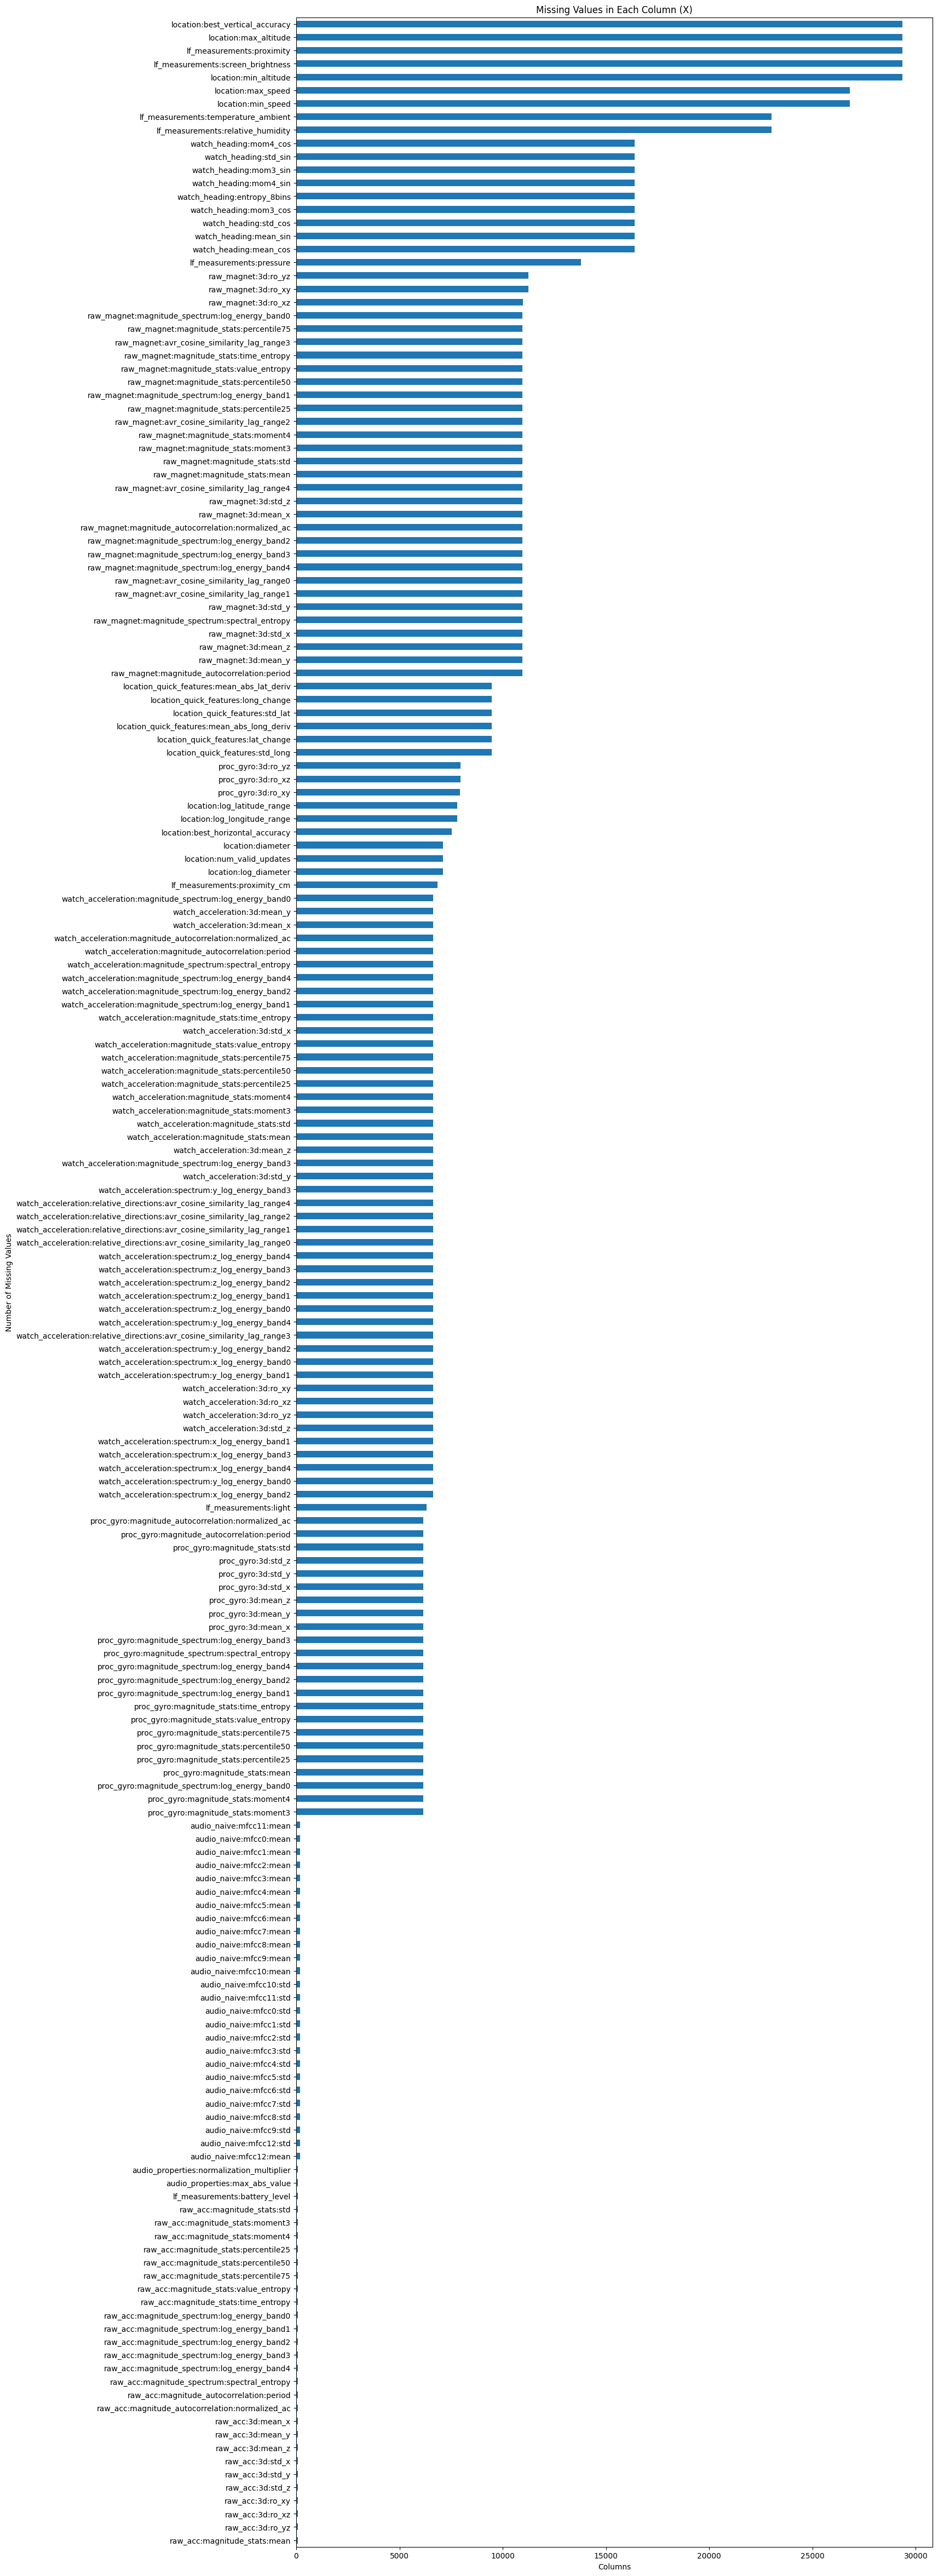

/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_4080/2398456764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(-1, inplace=True)


In [13]:
missing_value_check(X, 'X')
X.fillna(-1, inplace=True)
#TODO: Need to find the best way to add the missing values

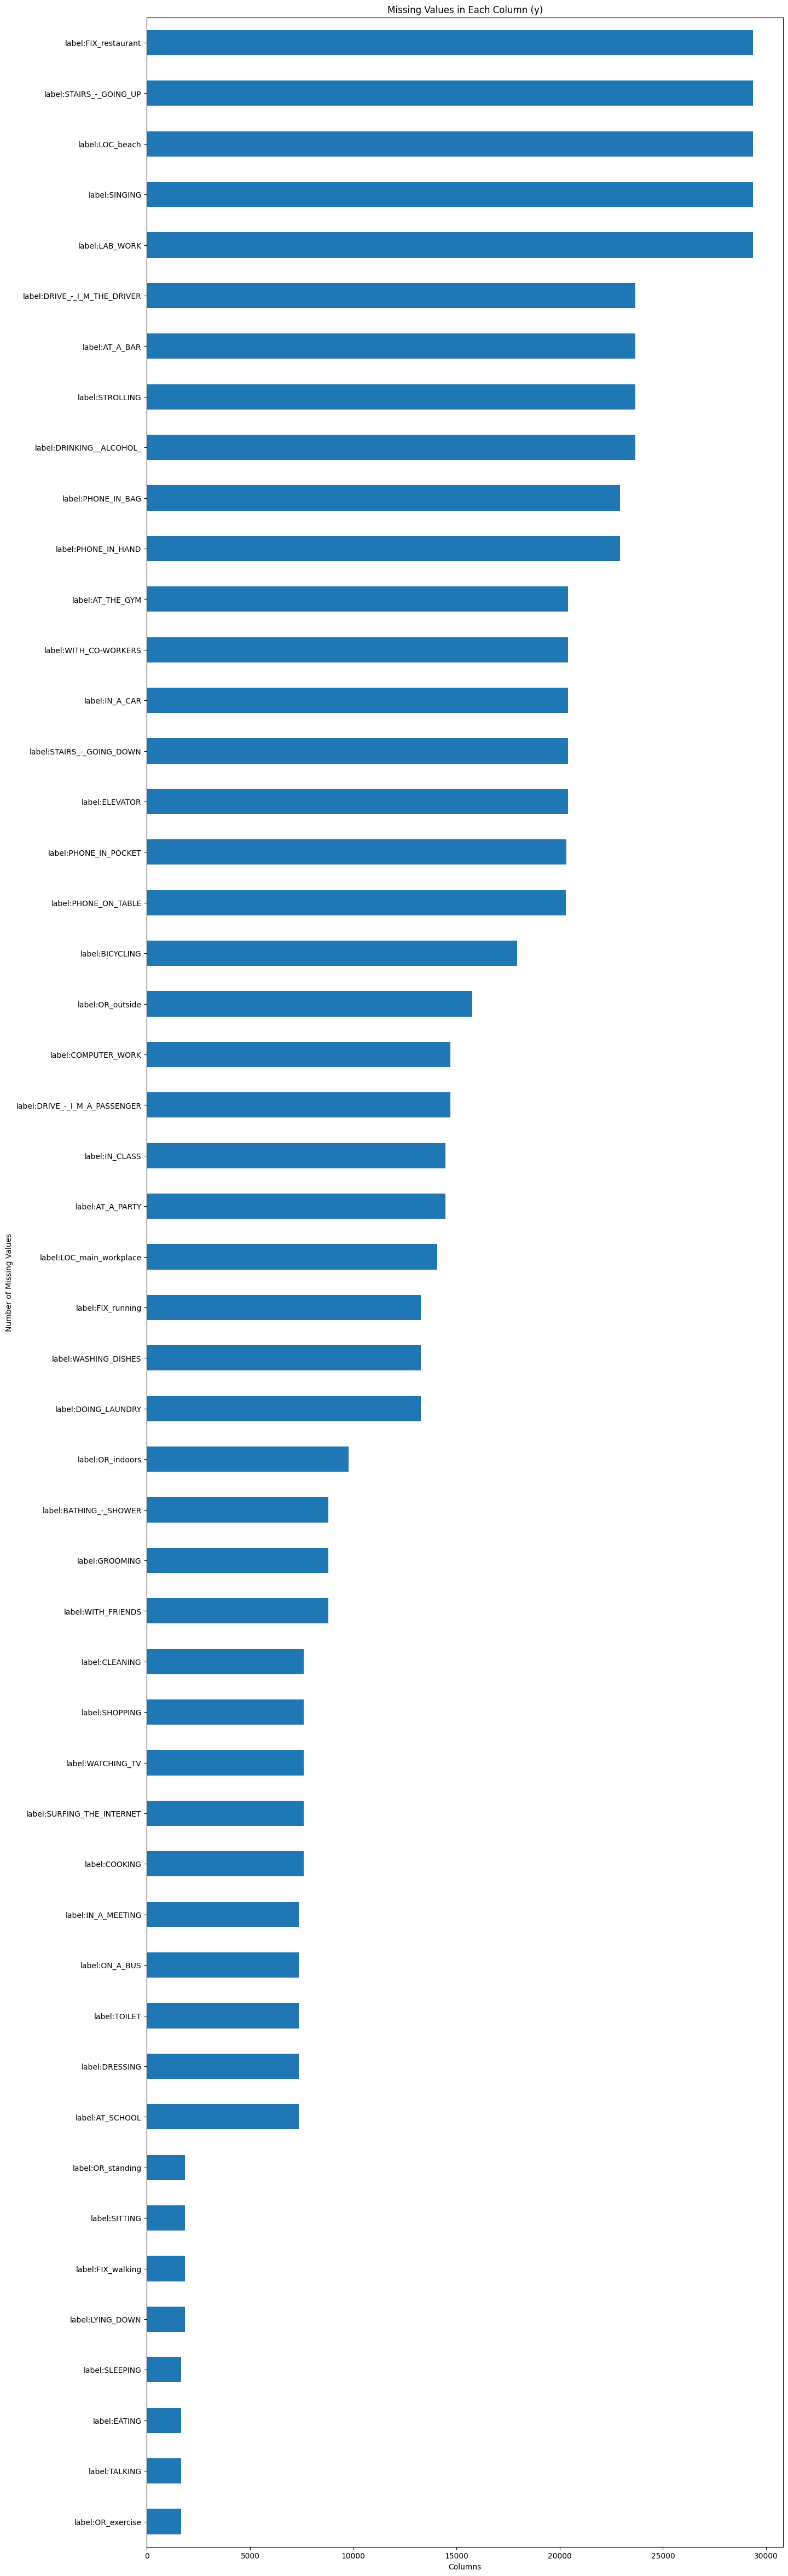

All the missing values have been covered.


/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_4080/1312125286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.fillna(0, inplace=True)


In [14]:
missing_value_check(y, 'y')
y.fillna(0, inplace=True)
missing_value_check(y, 'y')

## Model Testing


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
import tensorflow as tf


model = tf.keras.Sequential([
    tf.keras.Input(shape=(len(input_columns),)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(output_columns))]
)

In [17]:
model.compile(optimizer='adam', loss='mse')

#### JUST AN IMAGE
Only need few epochs:

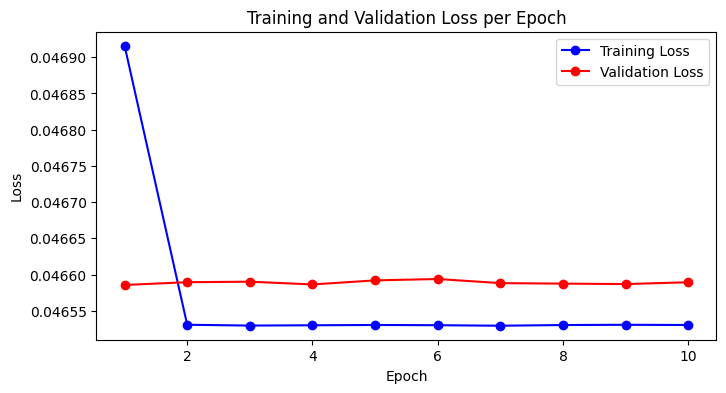
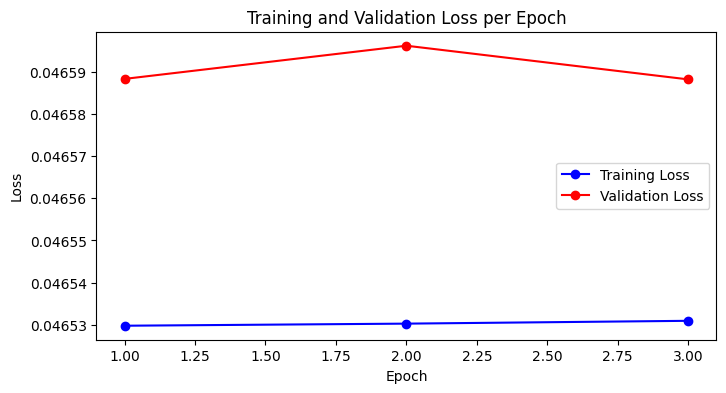

In [18]:
epochs = 3
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/3
514/514 [==============================] - 10s 18ms/step - loss: 265207989403648.0000 - val_loss: 16220.5537
Epoch 2/3
514/514 [==============================] - 2s 5ms/step - loss: 16198.3203 - val_loss: 15281.2402
Epoch 3/3
514/514 [==============================] - 2s 5ms/step - loss: 493791648.0000 - val_loss: 82575944.0000


In [19]:
# Save the entire model to a file
model.save("tf_model_v2.h5")

/Users/zaina/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
print(y_test[1:3])
y_pred_0 = model.predict(X_test[1:3])
print(y_pred_0)

      label:LYING_DOWN  label:SITTING  label:FIX_walking  label:FIX_running  \
4209               1.0            0.0                0.0                0.0   
3455               0.0            0.0                0.0                0.0   

      label:BICYCLING  label:SLEEPING  label:LAB_WORK  label:IN_CLASS  \
4209              0.0             1.0             0.0             0.0   
3455              1.0             0.0             0.0             0.0   

      label:IN_A_MEETING  label:LOC_main_workplace  label:OR_indoors  \
4209                 0.0                       0.0               1.0   
3455                 0.0                       0.0               0.0   

      label:OR_outside  label:IN_A_CAR  label:ON_A_BUS  \
4209               0.0             0.0             0.0   
3455               0.0             0.0             0.0   

      label:DRIVE_-_I_M_THE_DRIVER  label:DRIVE_-_I_M_A_PASSENGER  \
4209                           0.0                            0.0   
3455        

In [21]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")

# Predictions
y_pred = model.predict(X_test)


276/276 [==============================] - 1s 4ms/step - loss: 82582624.0000
Test Loss: 82582624.0000
276/276 [==============================] - 1s 2ms/step


In [22]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (8806, 226)
y_test shape: (8806, 51)


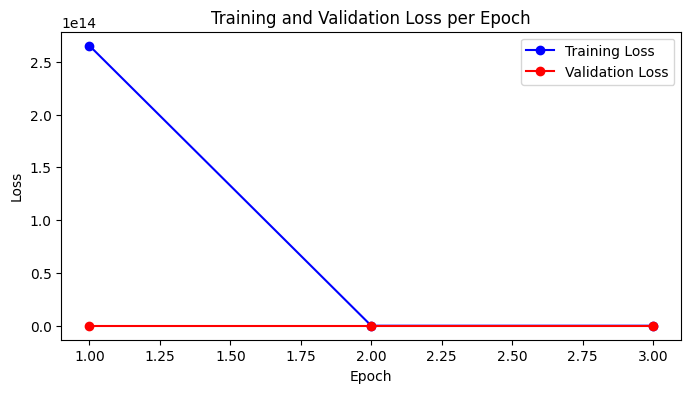

In [23]:
# Extracting loss and validation loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Creating epoch numbers (starting from 1)
epochs_range = range(1, epochs + 1)

# Plotting the training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [24]:
!pip3 freeze > requirements.txt

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# Assuming combined_csv_data is your DataFrame and it has been loaded already



# Before splitting, ensure there are no NaN values in your output columns
for col in output_columns:
    combined_csv_data[col].fillna(0, inplace=True)  # Replace NaN in y with 0, if appropriate

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_csv_data[input_columns], combined_csv_data[output_columns], test_size=0.2, random_state=42)

predictions = {}

for output_col in output_columns:
    # Create a pipeline with an imputer (to fill missing values in features) and logistic regression
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),  # Fills missing X values with the mean of each column
        LogisticRegression(max_iter=1000)  # Increased max_iter to ensure convergence
    )
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train[output_col])
    
    # New data for prediction. This example is simplified and should be replaced with actual new data.
    # Ensure X_new has the same number of features as X_train. Here, we use np.nan as placeholders.
    X_new = np.array([[0.5, 1.2] + [np.nan] * (224)])  # Adjusted to match the feature count of the trained model
    
    # Predicting the probability for the given X_new
    pred_prob = pipeline.predict_proba(X_new)[0][1]
    
    # Storing the prediction
    predictions[output_col] = pred_prob

# Displaying the predicted probabilities
for y_col, prob in predictions.items():
    print(f"Predicted probability for {y_col}: {prob:.2%}")


/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_4080/3046016783.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_csv_data[col].fillna(0, inplace=True)  # Replace NaN in y with 0, if appropriate
/Users/zaina/miniconda3/lib/python3.10/site-packages/sklearn/impute/_base.py:565: UserWarning: Skipping features without any observed values: ['location:min_altitude' 'location:max_altitude'
 'location:best_vertical_accuracy' 'lf_measurements:proximity'
 'lf_measurements:screen_brightness']. At least one non-miss

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0

In [ ]:
len(predictions)

51

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import warnings


warnings.filterwarnings("ignore", message="X does not have valid feature names, but SimpleImputer was fitted with feature names")

# Assuming combined_csv_data is your DataFrame and it has been loaded already
# Replace 'combined_csv_data' with the actual variable name of your DataFrame

# Fill missing values in output columns with a default value (e.g., 0)
y.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary to store the pipeline for each output column
pipelines = {}

# Train a pipeline for each output column
for output_col in output_columns:
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),  # Impute missing values
        LogisticRegression(max_iter=1000)  # Logistic regression
    )
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train[output_col])
    pipelines[output_col] = pipeline

# Predicting the probabilities for each row in X_test
predictions = {col: [] for col in output_columns}  # Initialize dictionary to store predictions

for index, row in X_test.iterrows():
    for output_col in output_columns:
        # Predict the probability for the current row and output column
        pred_prob = pipelines[output_col].predict_proba(row.values.reshape(1, -1))[0][1]
        predictions[output_col].append(pred_prob)

# Optionally, print out the predicted probabilities for the first few rows of X_test
for i, (index, row) in enumerate(X_test.iterrows()):
    if i >= 5:  # Limit output to first 5 rows
        break
    print(f"Predictions for row {index}:")
    for output_col in output_columns:
        print(f"  {output_col}: {predictions[output_col][i]:.2%}")
    print()  # Newline for readability


/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_43744/1352247473.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.fillna(0, inplace=True)


Predictions for row 225548:
  label:LYING_DOWN: 45.00%
  label:SITTING: 36.16%
  label:FIX_walking: 2.10%
  label:FIX_running: 0.29%
  label:BICYCLING: 0.49%
  label:SLEEPING: 22.02%
  label:LAB_WORK: 0.57%
  label:IN_CLASS: 1.63%
  label:IN_A_MEETING: 1.36%
  label:LOC_main_workplace: 9.00%
  label:OR_indoors: 63.17%
  label:OR_outside: 3.21%
  label:IN_A_CAR: 0.65%
  label:ON_A_BUS: 0.47%
  label:DRIVE_-_I_M_THE_DRIVER: 2.12%
  label:DRIVE_-_I_M_A_PASSENGER: 0.67%
  label:LOC_home: 49.30%
  label:FIX_restaurant: 0.55%
  label:PHONE_IN_POCKET: 6.24%
  label:OR_exercise: 0.83%
  label:COOKING: 1.06%
  label:SHOPPING: 0.49%
  label:STROLLING: 0.21%
  label:DRINKING__ALCOHOL_: 0.39%
  label:BATHING_-_SHOWER: 0.55%
  label:CLEANING: 1.02%
  label:DOING_LAUNDRY: 0.15%
  label:WASHING_DISHES: 0.33%
  label:WATCHING_TV: 3.51%
  label:SURFING_THE_INTERNET: 5.18%
  label:AT_A_PARTY: 0.39%
  label:AT_A_BAR: 0.15%
  label:LOC_beach: 0.09%
  label:SINGING: 0.17%
  label:TALKING: 9.61%
  label:COM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import warnings


warnings.filterwarnings("ignore", message="X does not have valid feature names, but SimpleImputer was fitted with feature names")

# Assuming combined_csv_data is your DataFrame and it has been loaded already
# Replace 'combined_csv_data' with the actual variable name of your DataFrame

# Fill missing values in output columns with a default value (e.g., 0)
y.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary to store the pipeline for each output column
pipelines = {}

# Train a pipeline for each output column
for output_col in output_columns:
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),  # Impute missing values
        LogisticRegression(max_iter=1000)  # Logistic regression
    )
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train[output_col])
    pipelines[output_col] = pipeline

# Predicting the probabilities for each row in X_test
predictions = {col: [] for col in output_columns}  # Initialize dictionary to store predictions

for index, row in X_test.iterrows():
    for output_col in output_columns:
        # Predict the probability for the current row and output column
        pred_prob = pipelines[output_col].predict_proba(row.values.reshape(1, -1))[0][1]
        predictions[output_col].append(pred_prob)

# Optionally, print out the predicted probabilities for the first few rows of X_test
for i, (index, row) in enumerate(X_test.iterrows()):
    if i >= 5:  # Limit output to first 5 rows
        break
    print(f"Predictions for row {index}:")
    for output_col in output_columns:
        print(f"  {output_col}: {predictions[output_col][i]:.2%}")
    print()  # Newline for readability


/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_43744/1352247473.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.fillna(0, inplace=True)


KeyboardInterrupt: 

In [ ]:
combined_csv_data.head()

NameError: name 'combined_csv_data' is not defined

In [ ]:
import pandas as pd
import numpy as np
from threading import Timer

class Phone:
    def __init__(self, data_df):
        self.data_df = data_df  # Assume data_df is a DataFrame loaded with user data

    def collect_data(self, userid):
        """Collects a random data row for a given user."""
        user_data = self.data_df[self.data_df['user_id'] == userid].sample(n=1)
        return user_data

    def process_data(self, userid, model):
        """Processes data using a specified model."""
        data = self.collect_data(userid)
        # Assuming `model` is a function passed to process the data
        processed_data = model(data)
        return processed_data

    def send_data(self, userid, interval, server):
        """Periodically sends data at specified intervals."""
        data = self.collect_data(userid)
        server.store_update_data(data)
        Timer(interval, self.send_data, args=[userid, interval, server]).start()

class Server:
    def __init__(self):
        self.storage_df = pd.DataFrame()  # Separate DataFrame for storing data

    def request_data(self, phone, userid, raw=True):
        """Requests data from the Phone class."""
        if raw:
            return phone.collect_data(userid)
        else:
            return phone.process_data(userid, self.process_data)  # Example: self.process_data as a placeholder

    def process_data(self, data):
        """Processes data."""
        # This is a placeholder for data processing logic, which could involve ML models or other transformations
        processed_data = data  # Simplified for demonstration
        return processed_data

    def store_update_data(self, data):
        """Stores or updates data in a separate DataFrame."""
        self.storage_df = pd.concat([self.storage_df, data], ignore_index=True)




In [ ]:
data_df = pd.read_csv('ExtraSensory_Combined_User_Data.csv')

In [ ]:
phone = Phone(data_df)
server = Server()

In [ ]:
userid="81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0"
raw_data = server.request_data(phone, userid, raw=True)
processed_data = server.request_data(phone, userid, raw=False)
server.store_update_data(raw_data)
server.store_update_data(processed_data)

In [ ]:
# df = X and y

# Format data into our stuture after predition

# Tablaue

# User - Dynamic
    # User Activity against timestamps
    # Porbablity Related - Select User and Time  (Log Reg) Probablities

In [ ]:
server.storage_df

timestamp  raw_acc:magnitude_stats:mean  raw_acc:magnitude_stats:std  \
0  1446541934                      1.020442                     0.001224   
1  1446295467                      1.035055                     0.004175   

   raw_acc:magnitude_stats:moment3  raw_acc:magnitude_stats:moment4  \
0                        -0.000816                         0.001642   
1                         0.003772                         0.005590   

   raw_acc:magnitude_stats:percentile25  raw_acc:magnitude_stats:percentile50  \
0                              1.019684                              1.020508   
1                              1.032436                              1.034281   

   raw_acc:magnitude_stats:percentile75  \
0                              1.021267   
1                              1.036872   

   raw_acc:magnitude_stats:value_entropy  \
0                               2.513081   
1                               2.462429   

   raw_acc:magnitude_stats:time_entropy  ...  label:ELEVATOR  \
0                              6.684611  ...             NaN   
1                              6.684604  ...             NaN   

   label:OR_standing  label:AT_SCHOOL  label:PHONE_IN_HAND  \
0                0.0              NaN                  NaN   
1                0.0              NaN                  NaN   

   label:PHONE_IN_BAG  label:PHONE_ON_TABLE  label:WITH_CO-WORKERS  \
0                 NaN                   NaN                    NaN   
1                 NaN                   NaN                    NaN   

   label:WITH_FRIENDS  label_source                               user_id  
0                 0.0             2  81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0  
1                 0.0             2  81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0  

[2 rows x 279 columns]

In [ ]:
data_df.head()

timestamp  raw_acc:magnitude_stats:mean  raw_acc:magnitude_stats:std  \
0  1446141691                      1.009726                     0.002838   
1  1446141752                      1.009822                     0.004624   
2  1446141805                      1.009667                     0.004781   
3  1446141873                      1.008839                     0.003543   
4  1446141925                      1.008193                     0.001753   

   raw_acc:magnitude_stats:moment3  raw_acc:magnitude_stats:moment4  \
0                        -0.002296                         0.005568   
1                         0.003040                         0.008459   
2                        -0.007802                         0.014457   
3                         0.001831                         0.007082   
4                        -0.000744                         0.002439   

   raw_acc:magnitude_stats:percentile25  raw_acc:magnitude_stats:percentile50  \
0                              1.008208                              1.009735   
1                              1.007704                              1.009619   
2                              1.008038                              1.009772   
3                              1.007134                              1.008803   
4                              1.007142                              1.008234   

   raw_acc:magnitude_stats:percentile75  \
0                              1.011174   
1                              1.011857   
2                              1.011139   
3                              1.010433   
4                              1.009350   

   raw_acc:magnitude_stats:value_entropy  \
0                               1.572784   
1                               1.754729   
2                               1.012852   
3                               1.511878   
4                               2.347186   

   raw_acc:magnitude_stats:time_entropy  ...  label:ELEVATOR  \
0                              6.684608  ...             NaN   
1                              6.684601  ...             NaN   
2                              6.684600  ...             NaN   
3                              6.684606  ...             NaN   
4                              6.684610  ...             NaN   

   label:OR_standing  label:AT_SCHOOL  label:PHONE_IN_HAND  \
0                0.0              NaN                  NaN   
1                0.0              NaN                  NaN   
2                0.0              NaN                  NaN   
3                0.0              NaN                  NaN   
4                0.0              NaN                  NaN   

   label:PHONE_IN_BAG  label:PHONE_ON_TABLE  label:WITH_CO-WORKERS  \
0                 NaN                   NaN                    NaN   
1                 NaN                   NaN                    NaN   
2                 NaN                   NaN                    NaN   
3                 NaN                   NaN                    NaN   
4                 NaN                   NaN                    NaN   

   label:WITH_FRIENDS  label_source                               user_id  
0                 0.0             2  81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0  
1                 0.0             2  81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0  
2                 0.0             2  81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0  
3                 0.0             2  81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0  
4                 0.0             2  81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0  

[5 rows x 279 columns]

In [51]:
len(combined_csv_data)

377346

In [50]:
nan_count_full = combined_csv_data[features].isna().sum()
nan_count_sorted_full = nan_count.sort_values(ascending=False)
nan_count_sorted_full


lf_measurements:proximity                                                  6407
location:best_vertical_accuracy                                            6407
location:max_altitude                                                      6407
location:min_altitude                                                      6407
lf_measurements:screen_brightness                                          6407
watch_heading:std_sin                                                       228
watch_heading:mean_sin                                                      228
watch_heading:mom4_cos                                                      228
watch_heading:mom3_cos                                                      228
watch_heading:std_cos                                                       228
watch_heading:mean_cos                                                      228
watch_heading:mom3_sin                                                      228
watch_heading:mom4_sin                  

In [36]:
hierarchy = build_hierarchy(X.columns)
formatted_hierarchy = format_hierarchy(hierarchy)
print(formatted_hierarchy)

- raw_acc:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  mean_x
    -  mean_y
    -  mean_z
    -  std_x
    -  std_y
    -  std_z
    -  ro_xy
    -  ro_xz
    -  ro_yz
- proc_gyro:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  mean_x
    -  m